<a href="https://colab.research.google.com/github/ceresnia/SRGANdata/blob/main/SRGAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# # https://youtu.be/nbRkLE2fiVI
# https://youtu.be/1HqjPqNglPc

"""

Dataset from: http://press.liacs.nl/mirflickr/mirdownload.html

Read high res. original images and save lower versions to be used for SRGAN.

Here, we are resizing them to 128x128 that will be  used as HR images and 
32x32 that will be used as LR images
"""

'\n\nDataset from: http://press.liacs.nl/mirflickr/mirdownload.html\n\nRead high res. original images and save lower versions to be used for SRGAN.\n\nHere, we are resizing them to 128x128 that will be  used as HR images and \n32x32 that will be used as LR images\n'

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
train_dir = "/content/drive/MyDrive/SRGANdata"

for img in os.listdir( train_dir + "/cars_train"):
    img_array = cv2.imread(train_dir + "/cars_train/" + img)
    
    img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.resize(img_array,(32,32))

    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    

In [24]:
# lr_list = os.listdir(train_dir + "/lr_images")[:n]

In [25]:
#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [26]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [27]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [28]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [29]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [30]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

In [33]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir(train_dir + "/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread(train_dir + "/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir(train_dir + "/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread(train_dir + "/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

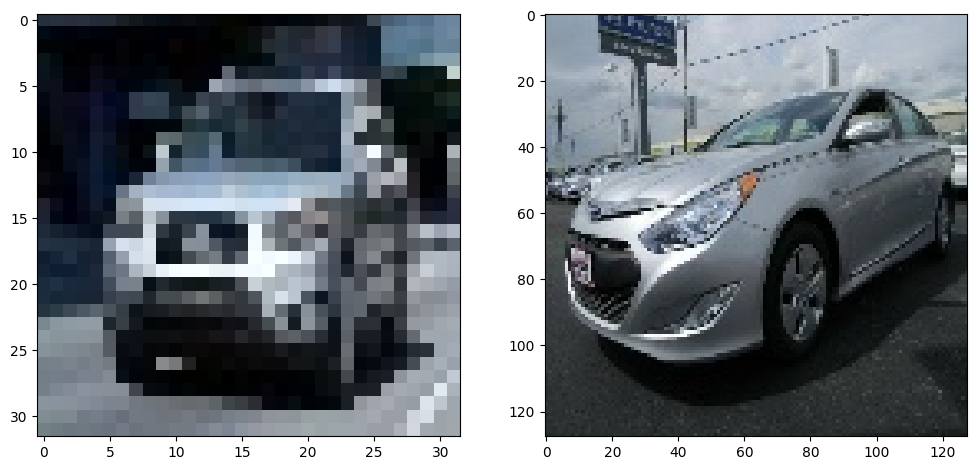

In [34]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [35]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [36]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [37]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [38]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 184ms/step


  0%|          | 1/3350 [00:28<26:54:49, 28.93s/it]

1/1 [==============================] - 0s 144ms/step


  0%|          | 2/3350 [00:33<13:42:37, 14.74s/it]

1/1 [==============================] - 0s 105ms/step


  0%|          | 3/3350 [00:37<8:56:29,  9.62s/it] 

1/1 [==============================] - 0s 101ms/step


  0%|          | 4/3350 [00:40<6:42:32,  7.22s/it]

1/1 [==============================] - 0s 105ms/step


  0%|          | 5/3350 [00:45<5:46:06,  6.21s/it]

1/1 [==============================] - 0s 106ms/step


  0%|          | 6/3350 [00:49<5:05:58,  5.49s/it]

1/1 [==============================] - 0s 102ms/step


  0%|          | 7/3350 [00:52<4:30:37,  4.86s/it]

1/1 [==============================] - 0s 100ms/step


  0%|          | 8/3350 [00:56<4:06:54,  4.43s/it]

1/1 [==============================] - 0s 148ms/step


  0%|          | 9/3350 [01:01<4:11:17,  4.51s/it]

1/1 [==============================] - 0s 100ms/step


  0%|          | 10/3350 [01:04<3:54:25,  4.21s/it]

1/1 [==============================] - 0s 104ms/step


  0%|          | 11/3350 [01:08<3:43:43,  4.02s/it]

1/1 [==============================] - 0s 106ms/step


  0%|          | 12/3350 [01:12<3:56:36,  4.25s/it]

1/1 [==============================] - 0s 111ms/step


  0%|          | 13/3350 [01:16<3:46:17,  4.07s/it]

1/1 [==============================] - 0s 113ms/step


  0%|          | 14/3350 [01:20<3:37:36,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


  0%|          | 15/3350 [01:24<3:37:48,  3.92s/it]

1/1 [==============================] - 0s 166ms/step


  0%|          | 16/3350 [01:28<3:44:38,  4.04s/it]

1/1 [==============================] - 0s 102ms/step


  1%|          | 17/3350 [01:31<3:35:50,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


  1%|          | 18/3350 [01:36<3:50:17,  4.15s/it]

1/1 [==============================] - 0s 156ms/step


  1%|          | 19/3350 [01:41<3:56:55,  4.27s/it]

1/1 [==============================] - 0s 104ms/step


  1%|          | 20/3350 [01:44<3:44:27,  4.04s/it]

1/1 [==============================] - 0s 103ms/step


  1%|          | 21/3350 [01:48<3:35:55,  3.89s/it]

1/1 [==============================] - 0s 155ms/step


  1%|          | 22/3350 [01:53<3:49:44,  4.14s/it]

1/1 [==============================] - 0s 103ms/step


  1%|          | 23/3350 [01:56<3:39:02,  3.95s/it]

1/1 [==============================] - 0s 104ms/step


  1%|          | 24/3350 [02:00<3:32:54,  3.84s/it]

1/1 [==============================] - 0s 111ms/step


  1%|          | 25/3350 [02:04<3:38:33,  3.94s/it]

1/1 [==============================] - 0s 100ms/step


  1%|          | 26/3350 [02:08<3:42:06,  4.01s/it]

1/1 [==============================] - 0s 102ms/step


  1%|          | 27/3350 [02:12<3:34:19,  3.87s/it]

1/1 [==============================] - 0s 99ms/step


  1%|          | 28/3350 [02:15<3:29:35,  3.79s/it]

1/1 [==============================] - 0s 155ms/step


  1%|          | 29/3350 [02:20<3:45:23,  4.07s/it]

1/1 [==============================] - 0s 102ms/step


  1%|          | 30/3350 [02:23<3:35:53,  3.90s/it]

1/1 [==============================] - 0s 112ms/step


  1%|          | 31/3350 [02:27<3:29:52,  3.79s/it]

1/1 [==============================] - 0s 113ms/step


  1%|          | 32/3350 [02:32<3:44:30,  4.06s/it]

1/1 [==============================] - 0s 108ms/step


  1%|          | 33/3350 [02:35<3:38:27,  3.95s/it]

1/1 [==============================] - 0s 98ms/step


  1%|          | 34/3350 [02:39<3:31:25,  3.83s/it]

1/1 [==============================] - 0s 100ms/step


  1%|          | 35/3350 [02:43<3:28:55,  3.78s/it]

1/1 [==============================] - 0s 140ms/step


  1%|          | 36/3350 [02:47<3:41:22,  4.01s/it]

1/1 [==============================] - 0s 105ms/step


  1%|          | 37/3350 [02:51<3:34:07,  3.88s/it]

1/1 [==============================] - 0s 102ms/step


  1%|          | 38/3350 [02:54<3:28:00,  3.77s/it]

1/1 [==============================] - 0s 138ms/step


  1%|          | 39/3350 [02:59<3:44:16,  4.06s/it]

1/1 [==============================] - 0s 133ms/step


  1%|          | 40/3350 [03:05<4:10:42,  4.54s/it]

1/1 [==============================] - 0s 101ms/step


  1%|          | 41/3350 [03:08<3:53:56,  4.24s/it]

1/1 [==============================] - 0s 145ms/step


  1%|▏         | 42/3350 [03:13<4:01:17,  4.38s/it]

1/1 [==============================] - 0s 104ms/step


  1%|▏         | 43/3350 [03:16<3:48:20,  4.14s/it]

1/1 [==============================] - 0s 105ms/step


  1%|▏         | 44/3350 [03:20<3:38:26,  3.96s/it]

1/1 [==============================] - 0s 104ms/step


  1%|▏         | 45/3350 [03:25<3:49:28,  4.17s/it]

1/1 [==============================] - 0s 108ms/step


  1%|▏         | 46/3350 [03:28<3:41:24,  4.02s/it]

1/1 [==============================] - 0s 101ms/step


  1%|▏         | 47/3350 [03:32<3:33:07,  3.87s/it]

1/1 [==============================] - 0s 111ms/step


  1%|▏         | 48/3350 [03:36<3:31:14,  3.84s/it]

1/1 [==============================] - 0s 149ms/step


  1%|▏         | 49/3350 [03:40<3:42:30,  4.04s/it]

1/1 [==============================] - 0s 102ms/step


  1%|▏         | 50/3350 [03:44<3:34:23,  3.90s/it]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 51/3350 [03:47<3:28:51,  3.80s/it]

1/1 [==============================] - 0s 142ms/step


  2%|▏         | 52/3350 [03:52<3:50:38,  4.20s/it]

1/1 [==============================] - 0s 167ms/step


  2%|▏         | 53/3350 [03:58<4:08:42,  4.53s/it]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 54/3350 [04:01<3:52:29,  4.23s/it]

1/1 [==============================] - 0s 169ms/step


  2%|▏         | 55/3350 [04:06<4:00:58,  4.39s/it]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 56/3350 [04:09<3:46:20,  4.12s/it]

1/1 [==============================] - 0s 101ms/step


  2%|▏         | 57/3350 [04:13<3:37:26,  3.96s/it]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 58/3350 [04:18<3:50:34,  4.20s/it]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 59/3350 [04:21<3:39:45,  4.01s/it]

1/1 [==============================] - 0s 108ms/step


  2%|▏         | 60/3350 [04:25<3:31:01,  3.85s/it]

1/1 [==============================] - 0s 101ms/step


  2%|▏         | 61/3350 [04:29<3:31:55,  3.87s/it]

1/1 [==============================] - 0s 142ms/step


  2%|▏         | 62/3350 [04:33<3:40:02,  4.02s/it]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 63/3350 [04:37<3:32:02,  3.87s/it]

1/1 [==============================] - 0s 221ms/step


  2%|▏         | 64/3350 [04:45<4:48:49,  5.27s/it]

1/1 [==============================] - 0s 107ms/step


  2%|▏         | 65/3350 [04:50<4:41:57,  5.15s/it]

1/1 [==============================] - 0s 112ms/step


  2%|▏         | 66/3350 [04:54<4:18:44,  4.73s/it]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 67/3350 [04:58<4:13:11,  4.63s/it]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 68/3350 [05:02<4:04:27,  4.47s/it]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 69/3350 [05:06<3:50:31,  4.22s/it]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 70/3350 [05:09<3:41:00,  4.04s/it]

1/1 [==============================] - 0s 149ms/step


  2%|▏         | 71/3350 [05:14<3:52:12,  4.25s/it]

1/1 [==============================] - 0s 106ms/step


  2%|▏         | 72/3350 [05:18<3:41:49,  4.06s/it]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 73/3350 [05:21<3:33:38,  3.91s/it]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 74/3350 [05:26<3:46:08,  4.14s/it]

1/1 [==============================] - 0s 102ms/step


  2%|▏         | 75/3350 [05:30<3:37:28,  3.98s/it]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 76/3350 [05:33<3:30:53,  3.86s/it]

1/1 [==============================] - 0s 102ms/step


  2%|▏         | 77/3350 [05:38<3:43:57,  4.11s/it]

1/1 [==============================] - 0s 106ms/step


  2%|▏         | 78/3350 [05:42<3:45:01,  4.13s/it]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 79/3350 [05:46<3:36:46,  3.98s/it]

1/1 [==============================] - 0s 105ms/step


  2%|▏         | 80/3350 [05:49<3:31:33,  3.88s/it]

1/1 [==============================] - 0s 146ms/step


  2%|▏         | 81/3350 [05:54<3:45:40,  4.14s/it]

1/1 [==============================] - 0s 109ms/step


  2%|▏         | 82/3350 [05:58<3:36:41,  3.98s/it]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 83/3350 [06:02<3:34:06,  3.93s/it]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 84/3350 [06:06<3:48:34,  4.20s/it]

1/1 [==============================] - 0s 102ms/step


  3%|▎         | 85/3350 [06:10<3:38:29,  4.02s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 86/3350 [06:14<3:31:15,  3.88s/it]

1/1 [==============================] - 0s 108ms/step


  3%|▎         | 87/3350 [06:18<3:37:44,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


  3%|▎         | 88/3350 [06:22<3:40:08,  4.05s/it]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 89/3350 [06:26<3:34:08,  3.94s/it]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 90/3350 [06:29<3:27:47,  3.82s/it]

1/1 [==============================] - 0s 148ms/step


  3%|▎         | 91/3350 [06:34<3:44:46,  4.14s/it]

1/1 [==============================] - 0s 109ms/step


  3%|▎         | 92/3350 [06:38<3:35:15,  3.96s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 93/3350 [06:41<3:28:59,  3.85s/it]

1/1 [==============================] - 0s 148ms/step


  3%|▎         | 94/3350 [06:46<3:43:01,  4.11s/it]

1/1 [==============================] - 0s 102ms/step


  3%|▎         | 95/3350 [06:50<3:34:05,  3.95s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 96/3350 [06:53<3:28:03,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 97/3350 [06:58<3:39:48,  4.05s/it]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 98/3350 [07:02<3:37:07,  4.01s/it]

1/1 [==============================] - 0s 286ms/step


  3%|▎         | 99/3350 [07:07<3:59:40,  4.42s/it]

1/1 [==============================] - 0s 107ms/step


  3%|▎         | 100/3350 [07:12<4:06:38,  4.55s/it]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 101/3350 [07:15<3:52:04,  4.29s/it]

1/1 [==============================] - 0s 107ms/step


  3%|▎         | 102/3350 [07:19<3:40:57,  4.08s/it]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 103/3350 [07:23<3:42:12,  4.11s/it]

1/1 [==============================] - 0s 106ms/step


  3%|▎         | 104/3350 [07:28<3:45:33,  4.17s/it]

1/1 [==============================] - 0s 110ms/step


  3%|▎         | 105/3350 [07:31<3:37:38,  4.02s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 106/3350 [07:35<3:30:50,  3.90s/it]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 107/3350 [07:40<3:45:41,  4.18s/it]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 108/3350 [07:43<3:37:10,  4.02s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 109/3350 [07:47<3:29:38,  3.88s/it]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 110/3350 [07:52<3:45:34,  4.18s/it]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 111/3350 [07:55<3:35:36,  3.99s/it]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 112/3350 [07:59<3:30:01,  3.89s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 113/3350 [08:03<3:32:57,  3.95s/it]

1/1 [==============================] - 0s 105ms/step


  3%|▎         | 114/3350 [08:07<3:38:22,  4.05s/it]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 115/3350 [08:11<3:30:19,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


  3%|▎         | 116/3350 [08:14<3:25:07,  3.81s/it]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 117/3350 [08:19<3:40:12,  4.09s/it]

1/1 [==============================] - 0s 101ms/step


  4%|▎         | 118/3350 [08:23<3:32:44,  3.95s/it]

1/1 [==============================] - 0s 102ms/step


  4%|▎         | 119/3350 [08:26<3:26:38,  3.84s/it]

1/1 [==============================] - 0s 115ms/step


  4%|▎         | 120/3350 [08:31<3:43:06,  4.14s/it]

1/1 [==============================] - 0s 99ms/step


  4%|▎         | 121/3350 [08:35<3:34:43,  3.99s/it]

1/1 [==============================] - 0s 100ms/step


  4%|▎         | 122/3350 [08:39<3:27:58,  3.87s/it]

1/1 [==============================] - 0s 104ms/step


  4%|▎         | 123/3350 [08:43<3:31:36,  3.93s/it]

1/1 [==============================] - 0s 99ms/step


  4%|▎         | 124/3350 [08:47<3:37:42,  4.05s/it]

1/1 [==============================] - 0s 108ms/step


  4%|▎         | 125/3350 [08:50<3:30:03,  3.91s/it]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 126/3350 [08:54<3:24:58,  3.81s/it]

1/1 [==============================] - 0s 155ms/step


  4%|▍         | 127/3350 [08:59<3:39:54,  4.09s/it]

1/1 [==============================] - 0s 106ms/step


  4%|▍         | 128/3350 [09:02<3:30:53,  3.93s/it]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 129/3350 [09:06<3:24:57,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 130/3350 [09:11<3:41:00,  4.12s/it]

1/1 [==============================] - 0s 108ms/step


  4%|▍         | 131/3350 [09:14<3:32:08,  3.95s/it]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 132/3350 [09:18<3:27:17,  3.86s/it]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 133/3350 [09:22<3:30:40,  3.93s/it]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 134/3350 [09:26<3:36:32,  4.04s/it]

1/1 [==============================] - 0s 100ms/step


  4%|▍         | 135/3350 [09:30<3:29:12,  3.90s/it]

1/1 [==============================] - 0s 108ms/step


  4%|▍         | 136/3350 [09:34<3:23:25,  3.80s/it]

1/1 [==============================] - 0s 146ms/step


  4%|▍         | 137/3350 [09:38<3:38:44,  4.08s/it]

1/1 [==============================] - 0s 111ms/step


  4%|▍         | 138/3350 [09:42<3:30:35,  3.93s/it]

1/1 [==============================] - 0s 108ms/step


  4%|▍         | 139/3350 [09:45<3:25:41,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 140/3350 [09:50<3:37:32,  4.07s/it]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 141/3350 [09:54<3:32:00,  3.96s/it]

1/1 [==============================] - 0s 111ms/step


  4%|▍         | 142/3350 [09:57<3:25:41,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 143/3350 [10:01<3:25:58,  3.85s/it]

1/1 [==============================] - 0s 141ms/step


  4%|▍         | 144/3350 [10:06<3:40:01,  4.12s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 145/3350 [10:10<3:32:32,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 146/3350 [10:13<3:26:26,  3.87s/it]

1/1 [==============================] - 0s 144ms/step


  4%|▍         | 147/3350 [10:18<3:40:32,  4.13s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 148/3350 [10:22<3:32:30,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 149/3350 [10:25<3:28:51,  3.91s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 150/3350 [10:30<3:48:13,  4.28s/it]

1/1 [==============================] - 0s 106ms/step


  5%|▍         | 151/3350 [10:34<3:38:36,  4.10s/it]

1/1 [==============================] - 0s 101ms/step


  5%|▍         | 152/3350 [10:38<3:30:55,  3.96s/it]

1/1 [==============================] - 0s 104ms/step


  5%|▍         | 153/3350 [10:42<3:33:26,  4.01s/it]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 154/3350 [10:46<3:40:19,  4.14s/it]

1/1 [==============================] - 0s 102ms/step


  5%|▍         | 155/3350 [10:50<3:33:57,  4.02s/it]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 156/3350 [10:54<3:26:18,  3.88s/it]

1/1 [==============================] - 0s 148ms/step


  5%|▍         | 157/3350 [10:58<3:39:19,  4.12s/it]

1/1 [==============================] - 0s 104ms/step


  5%|▍         | 158/3350 [11:02<3:30:34,  3.96s/it]

1/1 [==============================] - 0s 105ms/step


  5%|▍         | 159/3350 [11:05<3:24:28,  3.84s/it]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 160/3350 [11:10<3:41:52,  4.17s/it]

1/1 [==============================] - 0s 103ms/step


  5%|▍         | 161/3350 [11:14<3:32:26,  4.00s/it]

1/1 [==============================] - 0s 101ms/step


  5%|▍         | 162/3350 [11:18<3:25:35,  3.87s/it]

1/1 [==============================] - 0s 106ms/step


  5%|▍         | 163/3350 [11:22<3:28:47,  3.93s/it]

1/1 [==============================] - 0s 98ms/step


  5%|▍         | 164/3350 [11:26<3:34:22,  4.04s/it]

1/1 [==============================] - 0s 102ms/step


  5%|▍         | 165/3350 [11:30<3:27:12,  3.90s/it]

1/1 [==============================] - 0s 111ms/step


  5%|▍         | 166/3350 [11:33<3:24:02,  3.84s/it]

1/1 [==============================] - 0s 151ms/step


  5%|▍         | 167/3350 [11:38<3:37:53,  4.11s/it]

1/1 [==============================] - 0s 104ms/step


  5%|▌         | 168/3350 [11:41<3:28:38,  3.93s/it]

1/1 [==============================] - 0s 103ms/step


  5%|▌         | 169/3350 [11:45<3:23:34,  3.84s/it]

1/1 [==============================] - 0s 100ms/step


  5%|▌         | 170/3350 [11:50<3:38:03,  4.11s/it]

1/1 [==============================] - 0s 104ms/step


  5%|▌         | 171/3350 [11:54<3:30:28,  3.97s/it]

1/1 [==============================] - 0s 102ms/step


  5%|▌         | 172/3350 [11:57<3:23:46,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


  5%|▌         | 173/3350 [12:01<3:25:54,  3.89s/it]

1/1 [==============================] - 0s 139ms/step


  5%|▌         | 174/3350 [12:05<3:32:08,  4.01s/it]

1/1 [==============================] - 0s 100ms/step


  5%|▌         | 175/3350 [12:09<3:25:12,  3.88s/it]

1/1 [==============================] - 0s 106ms/step


  5%|▌         | 176/3350 [12:12<3:20:01,  3.78s/it]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 177/3350 [12:18<3:44:53,  4.25s/it]

1/1 [==============================] - 0s 103ms/step


  5%|▌         | 178/3350 [12:21<3:34:08,  4.05s/it]

1/1 [==============================] - 0s 101ms/step


  5%|▌         | 179/3350 [12:25<3:26:29,  3.91s/it]

1/1 [==============================] - 0s 113ms/step


  5%|▌         | 180/3350 [12:30<3:39:34,  4.16s/it]

1/1 [==============================] - 0s 100ms/step


  5%|▌         | 181/3350 [12:33<3:32:11,  4.02s/it]

1/1 [==============================] - 0s 104ms/step


  5%|▌         | 182/3350 [12:37<3:24:25,  3.87s/it]

1/1 [==============================] - 0s 106ms/step


  5%|▌         | 183/3350 [12:41<3:30:33,  3.99s/it]

1/1 [==============================] - 0s 141ms/step


  5%|▌         | 184/3350 [12:46<3:36:44,  4.11s/it]

1/1 [==============================] - 0s 109ms/step


  6%|▌         | 185/3350 [12:49<3:28:50,  3.96s/it]

1/1 [==============================] - 0s 104ms/step


  6%|▌         | 186/3350 [12:53<3:22:14,  3.84s/it]

1/1 [==============================] - 0s 151ms/step


  6%|▌         | 187/3350 [12:57<3:36:46,  4.11s/it]

1/1 [==============================] - 0s 123ms/step


  6%|▌         | 188/3350 [13:01<3:29:38,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 189/3350 [13:05<3:23:05,  3.86s/it]

1/1 [==============================] - 0s 105ms/step


  6%|▌         | 190/3350 [13:09<3:36:50,  4.12s/it]

1/1 [==============================] - 0s 103ms/step


  6%|▌         | 191/3350 [13:13<3:27:50,  3.95s/it]

1/1 [==============================] - 0s 111ms/step


  6%|▌         | 192/3350 [13:17<3:22:20,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 193/3350 [13:20<3:22:21,  3.85s/it]

1/1 [==============================] - 0s 106ms/step


  6%|▌         | 194/3350 [13:25<3:33:29,  4.06s/it]

1/1 [==============================] - 0s 105ms/step


  6%|▌         | 195/3350 [13:29<3:24:19,  3.89s/it]

1/1 [==============================] - 0s 117ms/step


  6%|▌         | 196/3350 [13:32<3:19:59,  3.80s/it]

1/1 [==============================] - 0s 142ms/step


  6%|▌         | 197/3350 [13:37<3:33:41,  4.07s/it]

1/1 [==============================] - 0s 104ms/step


  6%|▌         | 198/3350 [13:40<3:25:32,  3.91s/it]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 199/3350 [13:44<3:21:22,  3.83s/it]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 200/3350 [13:48<3:31:14,  4.02s/it]

1/1 [==============================] - 0s 103ms/step


  6%|▌         | 201/3350 [13:52<3:27:59,  3.96s/it]

1/1 [==============================] - 0s 105ms/step


  6%|▌         | 202/3350 [13:56<3:22:15,  3.86s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▌         | 203/3350 [14:00<3:18:48,  3.79s/it]

1/1 [==============================] - 0s 146ms/step


  6%|▌         | 204/3350 [14:04<3:31:49,  4.04s/it]

1/1 [==============================] - 0s 106ms/step


  6%|▌         | 205/3350 [14:08<3:24:07,  3.89s/it]

1/1 [==============================] - 0s 107ms/step


  6%|▌         | 206/3350 [14:11<3:20:07,  3.82s/it]

1/1 [==============================] - 0s 147ms/step


  6%|▌         | 207/3350 [14:16<3:35:27,  4.11s/it]

1/1 [==============================] - 0s 104ms/step


  6%|▌         | 208/3350 [14:20<3:26:35,  3.95s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▌         | 209/3350 [14:23<3:20:54,  3.84s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▋         | 210/3350 [14:27<3:23:33,  3.89s/it]

1/1 [==============================] - 0s 105ms/step


  6%|▋         | 211/3350 [14:31<3:27:06,  3.96s/it]

1/1 [==============================] - 0s 106ms/step


  6%|▋         | 212/3350 [14:35<3:22:35,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


  6%|▋         | 213/3350 [14:39<3:16:31,  3.76s/it]

1/1 [==============================] - 0s 143ms/step


  6%|▋         | 214/3350 [14:43<3:30:38,  4.03s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▋         | 215/3350 [14:47<3:22:24,  3.87s/it]

1/1 [==============================] - 0s 214ms/step


  6%|▋         | 216/3350 [14:55<4:23:05,  5.04s/it]

1/1 [==============================] - 0s 101ms/step


  6%|▋         | 217/3350 [14:59<4:21:54,  5.02s/it]

1/1 [==============================] - 0s 102ms/step


  7%|▋         | 218/3350 [15:03<3:58:50,  4.58s/it]

1/1 [==============================] - 0s 106ms/step


  7%|▋         | 219/3350 [15:07<3:46:36,  4.34s/it]

1/1 [==============================] - 0s 148ms/step


  7%|▋         | 220/3350 [15:11<3:47:54,  4.37s/it]

1/1 [==============================] - 0s 103ms/step


  7%|▋         | 221/3350 [15:15<3:35:08,  4.13s/it]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 222/3350 [15:18<3:25:09,  3.94s/it]

1/1 [==============================] - 0s 154ms/step


  7%|▋         | 223/3350 [15:23<3:36:32,  4.16s/it]

1/1 [==============================] - 0s 114ms/step


  7%|▋         | 224/3350 [15:27<3:30:53,  4.05s/it]

1/1 [==============================] - 0s 108ms/step


  7%|▋         | 225/3350 [15:30<3:23:07,  3.90s/it]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 226/3350 [15:35<3:30:47,  4.05s/it]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 227/3350 [15:39<3:29:31,  4.03s/it]

1/1 [==============================] - 0s 107ms/step


  7%|▋         | 228/3350 [15:42<3:21:37,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 229/3350 [15:46<3:17:41,  3.80s/it]

1/1 [==============================] - 0s 145ms/step


  7%|▋         | 230/3350 [15:50<3:30:08,  4.04s/it]

1/1 [==============================] - 0s 106ms/step


  7%|▋         | 231/3350 [15:54<3:21:46,  3.88s/it]

1/1 [==============================] - 0s 103ms/step


  7%|▋         | 232/3350 [15:57<3:16:03,  3.77s/it]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 233/3350 [16:02<3:29:34,  4.03s/it]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 234/3350 [16:06<3:21:44,  3.88s/it]

1/1 [==============================] - 0s 103ms/step


  7%|▋         | 235/3350 [16:09<3:16:40,  3.79s/it]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 236/3350 [16:13<3:15:02,  3.76s/it]

1/1 [==============================] - 0s 159ms/step


  7%|▋         | 237/3350 [16:17<3:25:56,  3.97s/it]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 238/3350 [16:21<3:19:17,  3.84s/it]

1/1 [==============================] - 0s 116ms/step


  7%|▋         | 239/3350 [16:24<3:14:44,  3.76s/it]

1/1 [==============================] - 0s 142ms/step


  7%|▋         | 240/3350 [16:29<3:31:25,  4.08s/it]

1/1 [==============================] - 0s 111ms/step


  7%|▋         | 241/3350 [16:33<3:23:42,  3.93s/it]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 242/3350 [16:36<3:16:54,  3.80s/it]

1/1 [==============================] - 0s 110ms/step


  7%|▋         | 243/3350 [16:41<3:23:13,  3.92s/it]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 244/3350 [16:45<3:26:25,  3.99s/it]

1/1 [==============================] - 0s 105ms/step


  7%|▋         | 245/3350 [16:48<3:19:51,  3.86s/it]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 246/3350 [16:52<3:15:20,  3.78s/it]

1/1 [==============================] - 0s 151ms/step


  7%|▋         | 247/3350 [16:57<3:29:53,  4.06s/it]

1/1 [==============================] - 0s 110ms/step


  7%|▋         | 248/3350 [17:00<3:21:19,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


  7%|▋         | 249/3350 [17:04<3:15:25,  3.78s/it]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 250/3350 [17:08<3:29:40,  4.06s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 251/3350 [17:12<3:22:18,  3.92s/it]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 252/3350 [17:15<3:16:30,  3.81s/it]

1/1 [==============================] - 0s 118ms/step


  8%|▊         | 253/3350 [17:19<3:16:07,  3.80s/it]

1/1 [==============================] - 0s 149ms/step


  8%|▊         | 254/3350 [17:24<3:25:41,  3.99s/it]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 255/3350 [17:27<3:18:29,  3.85s/it]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 256/3350 [17:31<3:13:49,  3.76s/it]

1/1 [==============================] - 0s 227ms/step


  8%|▊         | 257/3350 [17:36<3:33:04,  4.13s/it]

1/1 [==============================] - 0s 103ms/step


  8%|▊         | 258/3350 [17:39<3:25:07,  3.98s/it]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 259/3350 [17:43<3:18:29,  3.85s/it]

1/1 [==============================] - 0s 110ms/step


  8%|▊         | 260/3350 [17:47<3:26:51,  4.02s/it]

1/1 [==============================] - 0s 106ms/step


  8%|▊         | 261/3350 [17:51<3:25:31,  3.99s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 262/3350 [17:55<3:19:42,  3.88s/it]

1/1 [==============================] - 0s 113ms/step


  8%|▊         | 263/3350 [17:58<3:14:55,  3.79s/it]

1/1 [==============================] - 0s 166ms/step


  8%|▊         | 264/3350 [18:03<3:26:54,  4.02s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 265/3350 [18:06<3:18:13,  3.86s/it]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 266/3350 [18:10<3:12:47,  3.75s/it]

1/1 [==============================] - 0s 108ms/step


  8%|▊         | 267/3350 [18:15<3:27:47,  4.04s/it]

1/1 [==============================] - 0s 103ms/step


  8%|▊         | 268/3350 [18:18<3:20:30,  3.90s/it]

1/1 [==============================] - 0s 107ms/step


  8%|▊         | 269/3350 [18:22<3:14:46,  3.79s/it]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 270/3350 [18:26<3:14:49,  3.80s/it]

1/1 [==============================] - 0s 146ms/step


  8%|▊         | 271/3350 [18:30<3:25:03,  4.00s/it]

1/1 [==============================] - 0s 107ms/step


  8%|▊         | 272/3350 [18:34<3:18:27,  3.87s/it]

1/1 [==============================] - 0s 125ms/step


  8%|▊         | 273/3350 [18:37<3:14:51,  3.80s/it]

1/1 [==============================] - 0s 141ms/step


  8%|▊         | 274/3350 [18:42<3:28:12,  4.06s/it]

1/1 [==============================] - 0s 113ms/step


  8%|▊         | 275/3350 [18:46<3:19:51,  3.90s/it]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 276/3350 [18:49<3:14:01,  3.79s/it]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 277/3350 [18:53<3:19:07,  3.89s/it]

1/1 [==============================] - 0s 106ms/step


  8%|▊         | 278/3350 [18:57<3:22:31,  3.96s/it]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 279/3350 [19:01<3:15:56,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 280/3350 [19:04<3:11:41,  3.75s/it]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 281/3350 [19:09<3:31:25,  4.13s/it]

1/1 [==============================] - 0s 105ms/step


  8%|▊         | 282/3350 [19:13<3:21:10,  3.93s/it]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 283/3350 [19:16<3:14:49,  3.81s/it]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 284/3350 [19:21<3:25:53,  4.03s/it]

1/1 [==============================] - 0s 104ms/step


  9%|▊         | 285/3350 [19:25<3:20:23,  3.92s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▊         | 286/3350 [19:28<3:13:58,  3.80s/it]

1/1 [==============================] - 0s 104ms/step


  9%|▊         | 287/3350 [19:32<3:10:21,  3.73s/it]

1/1 [==============================] - 0s 144ms/step


  9%|▊         | 288/3350 [19:36<3:22:40,  3.97s/it]

1/1 [==============================] - 0s 104ms/step


  9%|▊         | 289/3350 [19:40<3:15:16,  3.83s/it]

1/1 [==============================] - 0s 116ms/step


  9%|▊         | 290/3350 [19:43<3:10:37,  3.74s/it]

1/1 [==============================] - 0s 105ms/step


  9%|▊         | 291/3350 [19:48<3:24:46,  4.02s/it]

1/1 [==============================] - 0s 111ms/step


  9%|▊         | 292/3350 [19:51<3:18:22,  3.89s/it]

1/1 [==============================] - 0s 105ms/step


  9%|▊         | 293/3350 [19:55<3:12:34,  3.78s/it]

1/1 [==============================] - 0s 107ms/step


  9%|▉         | 294/3350 [19:59<3:12:09,  3.77s/it]

1/1 [==============================] - 0s 142ms/step


  9%|▉         | 295/3350 [20:03<3:21:39,  3.96s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 296/3350 [20:07<3:15:15,  3.84s/it]

1/1 [==============================] - 0s 101ms/step


  9%|▉         | 297/3350 [20:10<3:10:27,  3.74s/it]

1/1 [==============================] - 0s 144ms/step


  9%|▉         | 298/3350 [20:15<3:24:13,  4.01s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 299/3350 [20:19<3:18:23,  3.90s/it]

1/1 [==============================] - 0s 105ms/step


  9%|▉         | 300/3350 [20:22<3:12:26,  3.79s/it]

1/1 [==============================] - 0s 106ms/step


  9%|▉         | 301/3350 [20:26<3:16:22,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


  9%|▉         | 302/3350 [20:30<3:21:26,  3.97s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 303/3350 [20:34<3:14:08,  3.82s/it]

1/1 [==============================] - 0s 99ms/step


  9%|▉         | 304/3350 [20:37<3:09:31,  3.73s/it]

1/1 [==============================] - 0s 153ms/step


  9%|▉         | 305/3350 [20:42<3:24:10,  4.02s/it]

1/1 [==============================] - 0s 104ms/step


  9%|▉         | 306/3350 [20:46<3:24:03,  4.02s/it]

1/1 [==============================] - 0s 111ms/step


  9%|▉         | 307/3350 [20:50<3:17:22,  3.89s/it]

1/1 [==============================] - 0s 106ms/step


  9%|▉         | 308/3350 [20:54<3:31:11,  4.17s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 309/3350 [20:58<3:22:12,  3.99s/it]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 310/3350 [21:02<3:15:54,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


  9%|▉         | 311/3350 [21:06<3:17:44,  3.90s/it]

1/1 [==============================] - 0s 117ms/step


  9%|▉         | 312/3350 [21:10<3:23:32,  4.02s/it]

1/1 [==============================] - 0s 105ms/step


  9%|▉         | 313/3350 [21:13<3:16:29,  3.88s/it]

1/1 [==============================] - 0s 108ms/step


  9%|▉         | 314/3350 [21:17<3:11:25,  3.78s/it]

1/1 [==============================] - 0s 145ms/step


  9%|▉         | 315/3350 [21:22<3:25:38,  4.07s/it]

1/1 [==============================] - 0s 114ms/step


  9%|▉         | 316/3350 [21:25<3:17:20,  3.90s/it]

1/1 [==============================] - 0s 104ms/step


  9%|▉         | 317/3350 [21:29<3:12:09,  3.80s/it]

1/1 [==============================] - 0s 107ms/step


  9%|▉         | 318/3350 [21:33<3:25:39,  4.07s/it]

1/1 [==============================] - 0s 104ms/step


 10%|▉         | 319/3350 [21:37<3:18:57,  3.94s/it]

1/1 [==============================] - 0s 107ms/step


 10%|▉         | 320/3350 [21:41<3:13:19,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 10%|▉         | 321/3350 [21:44<3:12:47,  3.82s/it]

1/1 [==============================] - 0s 154ms/step


 10%|▉         | 322/3350 [21:49<3:23:07,  4.03s/it]

1/1 [==============================] - 0s 112ms/step


 10%|▉         | 323/3350 [21:52<3:15:13,  3.87s/it]

1/1 [==============================] - 0s 102ms/step


 10%|▉         | 324/3350 [21:56<3:09:48,  3.76s/it]

1/1 [==============================] - 0s 144ms/step


 10%|▉         | 325/3350 [22:01<3:24:37,  4.06s/it]

1/1 [==============================] - 0s 102ms/step


 10%|▉         | 326/3350 [22:04<3:16:05,  3.89s/it]

1/1 [==============================] - 0s 105ms/step


 10%|▉         | 327/3350 [22:08<3:11:05,  3.79s/it]

1/1 [==============================] - 0s 103ms/step


 10%|▉         | 328/3350 [22:12<3:16:22,  3.90s/it]

1/1 [==============================] - 0s 105ms/step


 10%|▉         | 329/3350 [22:16<3:20:56,  3.99s/it]

1/1 [==============================] - 0s 101ms/step


 10%|▉         | 330/3350 [22:20<3:15:04,  3.88s/it]

1/1 [==============================] - 0s 105ms/step


 10%|▉         | 331/3350 [22:23<3:10:26,  3.78s/it]

1/1 [==============================] - 0s 153ms/step


 10%|▉         | 332/3350 [22:28<3:25:07,  4.08s/it]

1/1 [==============================] - 0s 104ms/step


 10%|▉         | 333/3350 [22:32<3:20:21,  3.98s/it]

1/1 [==============================] - 0s 100ms/step


 10%|▉         | 334/3350 [22:35<3:13:54,  3.86s/it]

1/1 [==============================] - 0s 140ms/step


 10%|█         | 335/3350 [22:41<3:44:44,  4.47s/it]

1/1 [==============================] - 0s 99ms/step


 10%|█         | 336/3350 [22:46<3:45:00,  4.48s/it]

1/1 [==============================] - 0s 100ms/step


 10%|█         | 337/3350 [22:49<3:30:44,  4.20s/it]

1/1 [==============================] - 0s 148ms/step


 10%|█         | 338/3350 [22:54<3:40:15,  4.39s/it]

1/1 [==============================] - 0s 104ms/step


 10%|█         | 339/3350 [22:58<3:26:33,  4.12s/it]

1/1 [==============================] - 0s 104ms/step


 10%|█         | 340/3350 [23:01<3:17:16,  3.93s/it]

1/1 [==============================] - 0s 101ms/step


 10%|█         | 341/3350 [23:05<3:19:05,  3.97s/it]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 342/3350 [23:11<3:45:53,  4.51s/it]

1/1 [==============================] - 0s 108ms/step


 10%|█         | 343/3350 [23:15<3:32:09,  4.23s/it]

1/1 [==============================] - 0s 101ms/step


 10%|█         | 344/3350 [23:19<3:29:36,  4.18s/it]

1/1 [==============================] - 0s 99ms/step


 10%|█         | 345/3350 [23:23<3:28:42,  4.17s/it]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 346/3350 [23:26<3:17:52,  3.95s/it]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 347/3350 [23:30<3:10:22,  3.80s/it]

1/1 [==============================] - 0s 165ms/step


 10%|█         | 348/3350 [23:34<3:24:06,  4.08s/it]

1/1 [==============================] - 0s 101ms/step


 10%|█         | 349/3350 [23:38<3:15:42,  3.91s/it]

1/1 [==============================] - 0s 103ms/step


 10%|█         | 350/3350 [23:41<3:09:49,  3.80s/it]

1/1 [==============================] - 0s 104ms/step


 10%|█         | 351/3350 [23:46<3:15:49,  3.92s/it]

1/1 [==============================] - 0s 105ms/step


 11%|█         | 352/3350 [23:50<3:18:49,  3.98s/it]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 353/3350 [23:53<3:11:27,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 11%|█         | 354/3350 [23:57<3:06:30,  3.74s/it]

1/1 [==============================] - 0s 146ms/step


 11%|█         | 355/3350 [24:02<3:20:58,  4.03s/it]

1/1 [==============================] - 0s 105ms/step


 11%|█         | 356/3350 [24:05<3:13:55,  3.89s/it]

1/1 [==============================] - 0s 99ms/step


 11%|█         | 357/3350 [24:09<3:07:29,  3.76s/it]

1/1 [==============================] - 0s 109ms/step


 11%|█         | 358/3350 [24:13<3:16:50,  3.95s/it]

1/1 [==============================] - 0s 103ms/step


 11%|█         | 359/3350 [24:17<3:16:09,  3.94s/it]

1/1 [==============================] - 0s 108ms/step


 11%|█         | 360/3350 [24:20<3:09:47,  3.81s/it]

1/1 [==============================] - 0s 104ms/step


 11%|█         | 361/3350 [24:24<3:05:18,  3.72s/it]

1/1 [==============================] - 0s 150ms/step


 11%|█         | 362/3350 [24:29<3:25:09,  4.12s/it]

1/1 [==============================] - 0s 103ms/step


 11%|█         | 363/3350 [24:33<3:22:13,  4.06s/it]

1/1 [==============================] - 0s 109ms/step


 11%|█         | 364/3350 [24:36<3:14:49,  3.91s/it]

1/1 [==============================] - 0s 153ms/step


 11%|█         | 365/3350 [24:41<3:26:36,  4.15s/it]

1/1 [==============================] - 0s 103ms/step


 11%|█         | 366/3350 [24:45<3:16:55,  3.96s/it]

1/1 [==============================] - 0s 109ms/step


 11%|█         | 367/3350 [24:48<3:10:22,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 11%|█         | 368/3350 [24:53<3:18:39,  4.00s/it]

1/1 [==============================] - 0s 108ms/step


 11%|█         | 369/3350 [24:57<3:18:59,  4.01s/it]

1/1 [==============================] - 0s 205ms/step


 11%|█         | 370/3350 [25:03<3:57:29,  4.78s/it]

1/1 [==============================] - 0s 143ms/step


 11%|█         | 371/3350 [25:09<4:09:52,  5.03s/it]

1/1 [==============================] - 0s 102ms/step


 11%|█         | 372/3350 [25:12<3:47:25,  4.58s/it]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 373/3350 [25:16<3:31:32,  4.26s/it]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 374/3350 [25:21<3:38:47,  4.41s/it]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 375/3350 [25:24<3:25:34,  4.15s/it]

1/1 [==============================] - 0s 102ms/step


 11%|█         | 376/3350 [25:28<3:16:24,  3.96s/it]

1/1 [==============================] - 0s 105ms/step


 11%|█▏        | 377/3350 [25:31<3:13:09,  3.90s/it]

1/1 [==============================] - 0s 143ms/step


 11%|█▏        | 378/3350 [25:36<3:21:25,  4.07s/it]

1/1 [==============================] - 0s 110ms/step


 11%|█▏        | 379/3350 [25:39<3:14:43,  3.93s/it]

1/1 [==============================] - 0s 98ms/step


 11%|█▏        | 380/3350 [25:43<3:08:25,  3.81s/it]

1/1 [==============================] - 0s 144ms/step


 11%|█▏        | 381/3350 [25:48<3:22:02,  4.08s/it]

1/1 [==============================] - 0s 109ms/step


 11%|█▏        | 382/3350 [25:51<3:14:12,  3.93s/it]

1/1 [==============================] - 0s 108ms/step


 11%|█▏        | 383/3350 [25:55<3:08:04,  3.80s/it]

1/1 [==============================] - 0s 108ms/step


 11%|█▏        | 384/3350 [25:59<3:09:58,  3.84s/it]

1/1 [==============================] - 0s 154ms/step


 11%|█▏        | 385/3350 [26:03<3:18:51,  4.02s/it]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 386/3350 [26:07<3:11:01,  3.87s/it]

1/1 [==============================] - 0s 102ms/step


 12%|█▏        | 387/3350 [26:10<3:06:16,  3.77s/it]

1/1 [==============================] - 0s 144ms/step


 12%|█▏        | 388/3350 [26:15<3:19:22,  4.04s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 389/3350 [26:18<3:12:04,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 390/3350 [26:22<3:08:48,  3.83s/it]

1/1 [==============================] - 0s 108ms/step


 12%|█▏        | 391/3350 [26:26<3:16:07,  3.98s/it]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 392/3350 [26:30<3:16:29,  3.99s/it]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 393/3350 [26:34<3:10:24,  3.86s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 394/3350 [26:38<3:06:01,  3.78s/it]

1/1 [==============================] - 0s 150ms/step


 12%|█▏        | 395/3350 [26:42<3:21:22,  4.09s/it]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 396/3350 [26:46<3:12:45,  3.92s/it]

1/1 [==============================] - 0s 108ms/step


 12%|█▏        | 397/3350 [26:49<3:06:30,  3.79s/it]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 398/3350 [26:54<3:20:32,  4.08s/it]

1/1 [==============================] - 0s 99ms/step


 12%|█▏        | 399/3350 [26:58<3:12:31,  3.91s/it]

1/1 [==============================] - 0s 112ms/step


 12%|█▏        | 400/3350 [27:01<3:07:39,  3.82s/it]

1/1 [==============================] - 0s 106ms/step


 12%|█▏        | 401/3350 [27:05<3:11:59,  3.91s/it]

1/1 [==============================] - 0s 115ms/step


 12%|█▏        | 402/3350 [27:10<3:17:16,  4.01s/it]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 403/3350 [27:13<3:10:57,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 404/3350 [27:17<3:06:22,  3.80s/it]

1/1 [==============================] - 0s 146ms/step


 12%|█▏        | 405/3350 [27:22<3:19:06,  4.06s/it]

1/1 [==============================] - 0s 102ms/step


 12%|█▏        | 406/3350 [27:25<3:10:53,  3.89s/it]

1/1 [==============================] - 0s 99ms/step


 12%|█▏        | 407/3350 [27:29<3:05:25,  3.78s/it]

1/1 [==============================] - 0s 102ms/step


 12%|█▏        | 408/3350 [27:33<3:17:28,  4.03s/it]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 409/3350 [27:37<3:12:26,  3.93s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 410/3350 [27:40<3:07:04,  3.82s/it]

1/1 [==============================] - 0s 101ms/step


 12%|█▏        | 411/3350 [27:44<3:06:06,  3.80s/it]

1/1 [==============================] - 0s 151ms/step


 12%|█▏        | 412/3350 [27:49<3:17:06,  4.03s/it]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 413/3350 [27:52<3:09:52,  3.88s/it]

1/1 [==============================] - 0s 99ms/step


 12%|█▏        | 414/3350 [27:56<3:05:19,  3.79s/it]

1/1 [==============================] - 0s 143ms/step


 12%|█▏        | 415/3350 [28:00<3:18:27,  4.06s/it]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 416/3350 [28:04<3:10:36,  3.90s/it]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 417/3350 [28:08<3:05:18,  3.79s/it]

1/1 [==============================] - 0s 107ms/step


 12%|█▏        | 418/3350 [28:12<3:11:40,  3.92s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 419/3350 [28:16<3:12:42,  3.95s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 420/3350 [28:19<3:07:27,  3.84s/it]

1/1 [==============================] - 0s 107ms/step


 13%|█▎        | 421/3350 [28:23<3:01:58,  3.73s/it]

1/1 [==============================] - 0s 165ms/step


 13%|█▎        | 422/3350 [28:28<3:15:36,  4.01s/it]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 423/3350 [28:31<3:07:39,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 424/3350 [28:34<3:02:16,  3.74s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 425/3350 [28:39<3:13:53,  3.98s/it]

1/1 [==============================] - 0s 106ms/step


 13%|█▎        | 426/3350 [28:43<3:10:16,  3.90s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 427/3350 [28:46<3:04:46,  3.79s/it]

1/1 [==============================] - 0s 107ms/step


 13%|█▎        | 428/3350 [28:50<3:02:13,  3.74s/it]

1/1 [==============================] - 0s 146ms/step


 13%|█▎        | 429/3350 [28:54<3:13:18,  3.97s/it]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 430/3350 [28:58<3:05:27,  3.81s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 431/3350 [29:01<3:00:57,  3.72s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 432/3350 [29:06<3:15:45,  4.03s/it]

1/1 [==============================] - 0s 115ms/step


 13%|█▎        | 433/3350 [29:10<3:10:06,  3.91s/it]

1/1 [==============================] - 0s 117ms/step


 13%|█▎        | 434/3350 [29:13<3:05:06,  3.81s/it]

1/1 [==============================] - 0s 105ms/step


 13%|█▎        | 435/3350 [29:17<3:06:50,  3.85s/it]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 436/3350 [29:22<3:13:37,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 13%|█▎        | 437/3350 [29:25<3:06:17,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 438/3350 [29:28<3:00:37,  3.72s/it]

1/1 [==============================] - 0s 157ms/step


 13%|█▎        | 439/3350 [29:33<3:15:03,  4.02s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 440/3350 [29:37<3:07:38,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 441/3350 [29:40<3:02:21,  3.76s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 442/3350 [29:45<3:11:19,  3.95s/it]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 443/3350 [29:49<3:11:36,  3.95s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 444/3350 [29:52<3:06:25,  3.85s/it]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 445/3350 [29:56<3:01:14,  3.74s/it]

1/1 [==============================] - 0s 148ms/step


 13%|█▎        | 446/3350 [30:00<3:14:50,  4.03s/it]

1/1 [==============================] - 0s 99ms/step


 13%|█▎        | 447/3350 [30:04<3:06:32,  3.86s/it]

1/1 [==============================] - 0s 107ms/step


 13%|█▎        | 448/3350 [30:07<3:00:53,  3.74s/it]

1/1 [==============================] - 0s 105ms/step


 13%|█▎        | 449/3350 [30:12<3:16:01,  4.05s/it]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 450/3350 [30:16<3:09:05,  3.91s/it]

1/1 [==============================] - 0s 103ms/step


 13%|█▎        | 451/3350 [30:19<3:03:41,  3.80s/it]

1/1 [==============================] - 0s 109ms/step


 13%|█▎        | 452/3350 [30:23<3:02:36,  3.78s/it]

1/1 [==============================] - 0s 145ms/step


 14%|█▎        | 453/3350 [30:27<3:12:01,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▎        | 454/3350 [30:31<3:05:06,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 14%|█▎        | 455/3350 [30:35<3:02:06,  3.77s/it]

1/1 [==============================] - 0s 157ms/step


 14%|█▎        | 456/3350 [30:39<3:15:51,  4.06s/it]

1/1 [==============================] - 0s 103ms/step


 14%|█▎        | 457/3350 [30:43<3:08:16,  3.90s/it]

1/1 [==============================] - 0s 114ms/step


 14%|█▎        | 458/3350 [30:46<3:03:16,  3.80s/it]

1/1 [==============================] - 0s 101ms/step


 14%|█▎        | 459/3350 [30:50<3:08:05,  3.90s/it]

1/1 [==============================] - 0s 107ms/step


 14%|█▎        | 460/3350 [30:55<3:12:17,  3.99s/it]

1/1 [==============================] - 0s 110ms/step


 14%|█▍        | 461/3350 [30:58<3:05:09,  3.85s/it]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 462/3350 [31:02<2:59:42,  3.73s/it]

1/1 [==============================] - 0s 144ms/step


 14%|█▍        | 463/3350 [31:06<3:13:28,  4.02s/it]

1/1 [==============================] - 0s 112ms/step


 14%|█▍        | 464/3350 [31:10<3:06:18,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 465/3350 [31:14<3:06:48,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 466/3350 [31:19<3:20:17,  4.17s/it]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 467/3350 [31:22<3:10:51,  3.97s/it]

1/1 [==============================] - 0s 106ms/step


 14%|█▍        | 468/3350 [31:26<3:03:39,  3.82s/it]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 469/3350 [31:29<3:02:44,  3.81s/it]

1/1 [==============================] - 0s 143ms/step


 14%|█▍        | 470/3350 [31:34<3:10:03,  3.96s/it]

1/1 [==============================] - 0s 107ms/step


 14%|█▍        | 471/3350 [31:37<3:03:04,  3.82s/it]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 472/3350 [31:41<2:58:23,  3.72s/it]

1/1 [==============================] - 0s 142ms/step


 14%|█▍        | 473/3350 [31:45<3:12:27,  4.01s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 474/3350 [31:49<3:06:03,  3.88s/it]

1/1 [==============================] - 0s 106ms/step


 14%|█▍        | 475/3350 [31:52<3:00:09,  3.76s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 476/3350 [31:56<3:04:17,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 477/3350 [32:01<3:08:59,  3.95s/it]

1/1 [==============================] - 0s 104ms/step


 14%|█▍        | 478/3350 [32:04<3:02:59,  3.82s/it]

1/1 [==============================] - 0s 108ms/step


 14%|█▍        | 479/3350 [32:08<2:58:47,  3.74s/it]

1/1 [==============================] - 0s 149ms/step


 14%|█▍        | 480/3350 [32:12<3:12:00,  4.01s/it]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 481/3350 [32:16<3:04:51,  3.87s/it]

1/1 [==============================] - 0s 104ms/step


 14%|█▍        | 482/3350 [32:19<2:59:50,  3.76s/it]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 483/3350 [32:24<3:10:03,  3.98s/it]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 484/3350 [32:28<3:05:50,  3.89s/it]

1/1 [==============================] - 0s 104ms/step


 14%|█▍        | 485/3350 [32:31<3:00:03,  3.77s/it]

1/1 [==============================] - 0s 108ms/step


 15%|█▍        | 486/3350 [32:35<2:56:42,  3.70s/it]

1/1 [==============================] - 0s 140ms/step


 15%|█▍        | 487/3350 [32:39<3:09:46,  3.98s/it]

1/1 [==============================] - 0s 106ms/step


 15%|█▍        | 488/3350 [32:43<3:04:23,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 489/3350 [32:46<2:59:30,  3.76s/it]

1/1 [==============================] - 0s 106ms/step


 15%|█▍        | 490/3350 [32:51<3:13:05,  4.05s/it]

1/1 [==============================] - 0s 106ms/step


 15%|█▍        | 491/3350 [32:55<3:05:10,  3.89s/it]

1/1 [==============================] - 0s 105ms/step


 15%|█▍        | 492/3350 [32:58<3:00:10,  3.78s/it]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 493/3350 [33:02<3:00:19,  3.79s/it]

1/1 [==============================] - 0s 138ms/step


 15%|█▍        | 494/3350 [33:06<3:09:38,  3.98s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▍        | 495/3350 [33:10<3:02:50,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 15%|█▍        | 496/3350 [33:13<2:59:19,  3.77s/it]

1/1 [==============================] - 0s 145ms/step


 15%|█▍        | 497/3350 [33:18<3:11:36,  4.03s/it]

1/1 [==============================] - 0s 105ms/step


 15%|█▍        | 498/3350 [33:22<3:04:41,  3.89s/it]

1/1 [==============================] - 0s 106ms/step


 15%|█▍        | 499/3350 [33:25<2:59:41,  3.78s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▍        | 500/3350 [33:30<3:08:20,  3.97s/it]

1/1 [==============================] - 0s 102ms/step


 15%|█▍        | 501/3350 [33:34<3:07:50,  3.96s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▍        | 502/3350 [33:37<3:01:52,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 15%|█▌        | 503/3350 [33:41<2:57:24,  3.74s/it]

1/1 [==============================] - 0s 148ms/step


 15%|█▌        | 504/3350 [33:45<3:10:40,  4.02s/it]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 505/3350 [33:49<3:04:00,  3.88s/it]

1/1 [==============================] - 0s 107ms/step


 15%|█▌        | 506/3350 [33:52<2:59:03,  3.78s/it]

1/1 [==============================] - 0s 107ms/step


 15%|█▌        | 507/3350 [33:57<3:13:33,  4.09s/it]

1/1 [==============================] - 0s 105ms/step


 15%|█▌        | 508/3350 [34:01<3:06:45,  3.94s/it]

1/1 [==============================] - 0s 104ms/step


 15%|█▌        | 509/3350 [34:04<3:01:59,  3.84s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 510/3350 [34:08<3:05:14,  3.91s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 511/3350 [34:13<3:10:25,  4.02s/it]

1/1 [==============================] - 0s 104ms/step


 15%|█▌        | 512/3350 [34:16<3:04:26,  3.90s/it]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 513/3350 [34:20<2:59:54,  3.80s/it]

1/1 [==============================] - 0s 136ms/step


 15%|█▌        | 514/3350 [34:25<3:13:26,  4.09s/it]

1/1 [==============================] - 0s 102ms/step


 15%|█▌        | 515/3350 [34:28<3:05:26,  3.92s/it]

1/1 [==============================] - 0s 104ms/step


 15%|█▌        | 516/3350 [34:32<3:00:05,  3.81s/it]

1/1 [==============================] - 0s 99ms/step


 15%|█▌        | 517/3350 [34:36<3:09:47,  4.02s/it]

1/1 [==============================] - 0s 103ms/step


 15%|█▌        | 518/3350 [34:40<3:06:56,  3.96s/it]

1/1 [==============================] - 0s 106ms/step


 15%|█▌        | 519/3350 [34:44<3:02:09,  3.86s/it]

1/1 [==============================] - 0s 110ms/step


 16%|█▌        | 520/3350 [34:47<3:00:02,  3.82s/it]

1/1 [==============================] - 0s 141ms/step


 16%|█▌        | 521/3350 [34:52<3:10:04,  4.03s/it]

1/1 [==============================] - 0s 102ms/step


 16%|█▌        | 522/3350 [34:56<3:03:19,  3.89s/it]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 523/3350 [34:59<2:57:59,  3.78s/it]

1/1 [==============================] - 0s 129ms/step


 16%|█▌        | 524/3350 [35:04<3:12:20,  4.08s/it]

1/1 [==============================] - 0s 141ms/step


 16%|█▌        | 525/3350 [35:08<3:06:50,  3.97s/it]

1/1 [==============================] - 0s 106ms/step


 16%|█▌        | 526/3350 [35:11<3:00:20,  3.83s/it]

1/1 [==============================] - 0s 109ms/step


 16%|█▌        | 527/3350 [35:15<3:06:45,  3.97s/it]

1/1 [==============================] - 0s 111ms/step


 16%|█▌        | 528/3350 [35:19<3:07:23,  3.98s/it]

1/1 [==============================] - 0s 103ms/step


 16%|█▌        | 529/3350 [35:23<3:00:10,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 530/3350 [35:26<2:56:35,  3.76s/it]

1/1 [==============================] - 0s 153ms/step


 16%|█▌        | 531/3350 [35:31<3:11:24,  4.07s/it]

1/1 [==============================] - 0s 106ms/step


 16%|█▌        | 532/3350 [35:35<3:03:20,  3.90s/it]

1/1 [==============================] - 0s 115ms/step


 16%|█▌        | 533/3350 [35:38<2:58:43,  3.81s/it]

1/1 [==============================] - 0s 111ms/step


 16%|█▌        | 534/3350 [35:43<3:11:51,  4.09s/it]

1/1 [==============================] - 0s 99ms/step


 16%|█▌        | 535/3350 [35:47<3:05:22,  3.95s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 536/3350 [35:50<3:00:54,  3.86s/it]

1/1 [==============================] - 0s 101ms/step


 16%|█▌        | 537/3350 [35:54<3:04:23,  3.93s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 538/3350 [35:59<3:09:12,  4.04s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 539/3350 [36:02<3:02:07,  3.89s/it]

1/1 [==============================] - 0s 112ms/step


 16%|█▌        | 540/3350 [36:06<2:57:27,  3.79s/it]

1/1 [==============================] - 0s 152ms/step


 16%|█▌        | 541/3350 [36:11<3:11:45,  4.10s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▌        | 542/3350 [36:14<3:03:55,  3.93s/it]

1/1 [==============================] - 0s 103ms/step


 16%|█▌        | 543/3350 [36:18<2:58:52,  3.82s/it]

1/1 [==============================] - 0s 108ms/step


 16%|█▌        | 544/3350 [36:22<3:08:16,  4.03s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▋        | 545/3350 [36:26<3:05:12,  3.96s/it]

1/1 [==============================] - 0s 104ms/step


 16%|█▋        | 546/3350 [36:30<2:58:57,  3.83s/it]

1/1 [==============================] - 0s 102ms/step


 16%|█▋        | 547/3350 [36:33<2:55:13,  3.75s/it]

1/1 [==============================] - 0s 148ms/step


 16%|█▋        | 548/3350 [36:38<3:06:33,  3.99s/it]

1/1 [==============================] - 0s 102ms/step


 16%|█▋        | 549/3350 [36:41<2:59:30,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 16%|█▋        | 550/3350 [36:45<2:55:00,  3.75s/it]

1/1 [==============================] - 0s 107ms/step


 16%|█▋        | 551/3350 [36:49<3:08:20,  4.04s/it]

1/1 [==============================] - 0s 105ms/step


 16%|█▋        | 552/3350 [36:53<3:01:48,  3.90s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 553/3350 [36:57<2:56:13,  3.78s/it]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 554/3350 [37:00<2:56:11,  3.78s/it]

1/1 [==============================] - 0s 152ms/step


 17%|█▋        | 555/3350 [37:05<3:05:32,  3.98s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 556/3350 [37:08<2:59:29,  3.85s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 557/3350 [37:12<2:54:45,  3.75s/it]

1/1 [==============================] - 0s 152ms/step


 17%|█▋        | 558/3350 [37:17<3:08:57,  4.06s/it]

1/1 [==============================] - 0s 100ms/step


 17%|█▋        | 559/3350 [37:20<3:00:57,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 560/3350 [37:24<2:56:07,  3.79s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 561/3350 [37:28<2:59:37,  3.86s/it]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 562/3350 [37:32<3:04:52,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 563/3350 [37:35<2:58:19,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 564/3350 [37:39<2:54:00,  3.75s/it]

1/1 [==============================] - 0s 150ms/step


 17%|█▋        | 565/3350 [37:44<3:08:50,  4.07s/it]

1/1 [==============================] - 0s 109ms/step


 17%|█▋        | 566/3350 [37:47<3:01:05,  3.90s/it]

1/1 [==============================] - 0s 100ms/step


 17%|█▋        | 567/3350 [37:51<2:55:13,  3.78s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 568/3350 [37:55<3:06:56,  4.03s/it]

1/1 [==============================] - 0s 105ms/step


 17%|█▋        | 569/3350 [37:59<3:00:52,  3.90s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 570/3350 [38:03<2:56:06,  3.80s/it]

1/1 [==============================] - 0s 105ms/step


 17%|█▋        | 571/3350 [38:06<2:54:11,  3.76s/it]

1/1 [==============================] - 0s 108ms/step


 17%|█▋        | 572/3350 [38:11<3:07:16,  4.04s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 573/3350 [38:15<3:00:40,  3.90s/it]

1/1 [==============================] - 0s 114ms/step


 17%|█▋        | 574/3350 [38:18<2:55:00,  3.78s/it]

1/1 [==============================] - 0s 145ms/step


 17%|█▋        | 575/3350 [38:23<3:06:58,  4.04s/it]

1/1 [==============================] - 0s 105ms/step


 17%|█▋        | 576/3350 [38:26<2:59:59,  3.89s/it]

1/1 [==============================] - 0s 110ms/step


 17%|█▋        | 577/3350 [38:30<2:54:25,  3.77s/it]

1/1 [==============================] - 0s 99ms/step


 17%|█▋        | 578/3350 [38:34<3:03:04,  3.96s/it]

1/1 [==============================] - 0s 108ms/step


 17%|█▋        | 579/3350 [38:38<3:02:09,  3.94s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 580/3350 [38:42<2:55:18,  3.80s/it]

1/1 [==============================] - 0s 114ms/step


 17%|█▋        | 581/3350 [38:45<2:51:50,  3.72s/it]

1/1 [==============================] - 0s 146ms/step


 17%|█▋        | 582/3350 [38:50<3:05:27,  4.02s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 583/3350 [38:53<2:58:47,  3.88s/it]

1/1 [==============================] - 0s 105ms/step


 17%|█▋        | 584/3350 [38:57<2:54:18,  3.78s/it]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 585/3350 [39:02<3:06:48,  4.05s/it]

1/1 [==============================] - 0s 102ms/step


 17%|█▋        | 586/3350 [39:05<2:58:45,  3.88s/it]

1/1 [==============================] - 0s 110ms/step


 18%|█▊        | 587/3350 [39:09<2:52:46,  3.75s/it]

1/1 [==============================] - 0s 108ms/step


 18%|█▊        | 588/3350 [39:13<3:03:42,  3.99s/it]

1/1 [==============================] - 0s 142ms/step


 18%|█▊        | 589/3350 [39:18<3:10:09,  4.13s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 590/3350 [39:21<3:01:00,  3.93s/it]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 591/3350 [39:25<2:55:09,  3.81s/it]

1/1 [==============================] - 0s 144ms/step


 18%|█▊        | 592/3350 [39:29<3:07:05,  4.07s/it]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 593/3350 [39:33<2:58:58,  3.89s/it]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 594/3350 [39:36<2:53:12,  3.77s/it]

1/1 [==============================] - 0s 105ms/step


 18%|█▊        | 595/3350 [39:40<2:56:11,  3.84s/it]

1/1 [==============================] - 0s 113ms/step


 18%|█▊        | 596/3350 [39:44<3:01:40,  3.96s/it]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 597/3350 [39:48<2:55:15,  3.82s/it]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 598/3350 [39:52<3:00:36,  3.94s/it]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 599/3350 [39:57<3:07:54,  4.10s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 600/3350 [40:00<3:01:30,  3.96s/it]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 601/3350 [40:04<2:56:58,  3.86s/it]

1/1 [==============================] - 0s 144ms/step


 18%|█▊        | 602/3350 [40:08<3:06:44,  4.08s/it]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 603/3350 [40:12<2:59:09,  3.91s/it]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 604/3350 [40:16<2:55:45,  3.84s/it]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 605/3350 [40:20<3:06:53,  4.09s/it]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 606/3350 [40:24<3:00:38,  3.95s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 607/3350 [40:27<2:54:40,  3.82s/it]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 608/3350 [40:32<2:59:19,  3.92s/it]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 609/3350 [40:36<3:00:21,  3.95s/it]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 610/3350 [40:39<2:55:05,  3.83s/it]

1/1 [==============================] - 0s 114ms/step


 18%|█▊        | 611/3350 [40:43<2:53:22,  3.80s/it]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 612/3350 [40:47<3:02:12,  3.99s/it]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 613/3350 [40:51<2:56:31,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 614/3350 [40:55<2:52:42,  3.79s/it]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 615/3350 [40:59<3:02:30,  4.00s/it]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 616/3350 [41:03<2:58:12,  3.91s/it]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 617/3350 [41:06<2:53:57,  3.82s/it]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 618/3350 [41:11<3:04:33,  4.05s/it]

1/1 [==============================] - 0s 104ms/step


 18%|█▊        | 619/3350 [41:15<2:58:18,  3.92s/it]

1/1 [==============================] - 0s 103ms/step


 19%|█▊        | 620/3350 [41:18<2:54:26,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


 19%|█▊        | 621/3350 [41:22<2:58:15,  3.92s/it]

1/1 [==============================] - 0s 98ms/step


 19%|█▊        | 622/3350 [41:26<2:59:29,  3.95s/it]

1/1 [==============================] - 0s 106ms/step


 19%|█▊        | 623/3350 [41:30<3:01:18,  3.99s/it]

1/1 [==============================] - 0s 121ms/step


 19%|█▊        | 624/3350 [41:35<3:13:02,  4.25s/it]

1/1 [==============================] - 0s 117ms/step


 19%|█▊        | 625/3350 [41:40<3:17:46,  4.35s/it]

1/1 [==============================] - 0s 119ms/step


 19%|█▊        | 626/3350 [41:44<3:16:26,  4.33s/it]

1/1 [==============================] - 0s 123ms/step


 19%|█▊        | 627/3350 [41:51<3:48:57,  5.05s/it]

1/1 [==============================] - 0s 129ms/step


 19%|█▊        | 628/3350 [41:55<3:35:46,  4.76s/it]

1/1 [==============================] - 0s 124ms/step


 19%|█▉        | 629/3350 [41:59<3:24:14,  4.50s/it]

1/1 [==============================] - 0s 141ms/step


 19%|█▉        | 630/3350 [42:03<3:24:03,  4.50s/it]

1/1 [==============================] - 0s 108ms/step


 19%|█▉        | 631/3350 [42:07<3:12:14,  4.24s/it]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 632/3350 [42:11<3:03:27,  4.05s/it]

1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 633/3350 [42:15<3:11:12,  4.22s/it]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 634/3350 [42:19<3:03:07,  4.05s/it]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 635/3350 [42:22<2:56:48,  3.91s/it]

1/1 [==============================] - 0s 106ms/step


 19%|█▉        | 636/3350 [42:27<3:00:32,  3.99s/it]

1/1 [==============================] - 0s 105ms/step


 19%|█▉        | 637/3350 [42:31<3:01:32,  4.01s/it]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 638/3350 [42:34<2:55:14,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 19%|█▉        | 639/3350 [42:38<2:51:52,  3.80s/it]

1/1 [==============================] - 0s 103ms/step


 19%|█▉        | 640/3350 [42:43<3:06:21,  4.13s/it]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 641/3350 [42:46<2:59:40,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 642/3350 [42:50<2:54:23,  3.86s/it]

1/1 [==============================] - 0s 152ms/step


 19%|█▉        | 643/3350 [42:54<3:02:37,  4.05s/it]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 644/3350 [42:58<2:55:13,  3.89s/it]

1/1 [==============================] - 0s 107ms/step


 19%|█▉        | 645/3350 [43:01<2:50:23,  3.78s/it]

1/1 [==============================] - 0s 146ms/step


 19%|█▉        | 646/3350 [43:06<3:00:02,  4.00s/it]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 647/3350 [43:09<2:53:42,  3.86s/it]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 648/3350 [43:13<2:49:18,  3.76s/it]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 649/3350 [43:18<3:01:10,  4.02s/it]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 650/3350 [43:21<2:54:45,  3.88s/it]

1/1 [==============================] - 0s 100ms/step


 19%|█▉        | 651/3350 [43:25<2:49:50,  3.78s/it]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 652/3350 [43:29<2:50:35,  3.79s/it]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 653/3350 [43:33<2:55:49,  3.91s/it]

1/1 [==============================] - 0s 101ms/step


 20%|█▉        | 654/3350 [43:36<2:51:16,  3.81s/it]

1/1 [==============================] - 0s 101ms/step


 20%|█▉        | 655/3350 [43:40<2:47:52,  3.74s/it]

1/1 [==============================] - 0s 138ms/step


 20%|█▉        | 656/3350 [43:44<2:57:56,  3.96s/it]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 657/3350 [43:48<2:52:11,  3.84s/it]

1/1 [==============================] - 0s 101ms/step


 20%|█▉        | 658/3350 [43:51<2:48:07,  3.75s/it]

1/1 [==============================] - 0s 102ms/step


 20%|█▉        | 659/3350 [43:56<2:58:59,  3.99s/it]

1/1 [==============================] - 0s 103ms/step


 20%|█▉        | 660/3350 [44:00<2:53:11,  3.86s/it]

1/1 [==============================] - 0s 107ms/step


 20%|█▉        | 661/3350 [44:03<2:49:14,  3.78s/it]

1/1 [==============================] - 0s 100ms/step


 20%|█▉        | 662/3350 [44:07<2:51:30,  3.83s/it]

1/1 [==============================] - 0s 101ms/step


 20%|█▉        | 663/3350 [44:11<2:56:22,  3.94s/it]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 664/3350 [44:15<2:51:42,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 20%|█▉        | 665/3350 [44:18<2:47:57,  3.75s/it]

1/1 [==============================] - 0s 146ms/step


 20%|█▉        | 666/3350 [44:23<2:57:42,  3.97s/it]

1/1 [==============================] - 0s 102ms/step


 20%|█▉        | 667/3350 [44:26<2:51:38,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 20%|█▉        | 668/3350 [44:30<2:47:57,  3.76s/it]

1/1 [==============================] - 0s 138ms/step


 20%|█▉        | 669/3350 [44:35<2:59:28,  4.02s/it]

1/1 [==============================] - 0s 101ms/step


 20%|██        | 670/3350 [44:38<2:53:53,  3.89s/it]

1/1 [==============================] - 0s 99ms/step


 20%|██        | 671/3350 [44:42<2:49:31,  3.80s/it]

1/1 [==============================] - 0s 107ms/step


 20%|██        | 672/3350 [44:46<2:59:37,  4.02s/it]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 673/3350 [44:50<2:54:59,  3.92s/it]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 674/3350 [44:54<2:50:41,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 675/3350 [44:58<2:50:58,  3.84s/it]

1/1 [==============================] - 0s 107ms/step


 20%|██        | 676/3350 [45:02<2:56:34,  3.96s/it]

1/1 [==============================] - 0s 98ms/step


 20%|██        | 677/3350 [45:06<2:55:35,  3.94s/it]

1/1 [==============================] - 0s 100ms/step


 20%|██        | 678/3350 [45:09<2:50:18,  3.82s/it]

1/1 [==============================] - 0s 149ms/step


 20%|██        | 679/3350 [45:14<2:58:51,  4.02s/it]

1/1 [==============================] - 0s 112ms/step


 20%|██        | 680/3350 [45:17<2:52:41,  3.88s/it]

1/1 [==============================] - 0s 102ms/step


 20%|██        | 681/3350 [45:21<2:48:25,  3.79s/it]

1/1 [==============================] - 0s 167ms/step


 20%|██        | 682/3350 [45:25<2:58:29,  4.01s/it]

1/1 [==============================] - 0s 105ms/step


 20%|██        | 683/3350 [45:29<2:53:09,  3.90s/it]

1/1 [==============================] - 0s 113ms/step


 20%|██        | 684/3350 [45:33<2:49:57,  3.82s/it]

1/1 [==============================] - 0s 104ms/step


 20%|██        | 685/3350 [45:37<2:59:51,  4.05s/it]

1/1 [==============================] - 0s 105ms/step


 20%|██        | 686/3350 [45:41<2:53:36,  3.91s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 687/3350 [45:44<2:49:05,  3.81s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 688/3350 [45:49<2:55:19,  3.95s/it]

1/1 [==============================] - 0s 107ms/step


 21%|██        | 689/3350 [45:53<2:56:01,  3.97s/it]

1/1 [==============================] - 0s 111ms/step


 21%|██        | 690/3350 [45:56<2:51:21,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


 21%|██        | 691/3350 [46:00<2:50:49,  3.85s/it]

1/1 [==============================] - 0s 127ms/step


 21%|██        | 692/3350 [46:04<2:56:45,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 21%|██        | 693/3350 [46:08<2:51:31,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 694/3350 [46:12<2:47:52,  3.79s/it]

1/1 [==============================] - 0s 143ms/step


 21%|██        | 695/3350 [46:16<2:57:39,  4.01s/it]

1/1 [==============================] - 0s 106ms/step


 21%|██        | 696/3350 [46:20<2:51:51,  3.89s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 697/3350 [46:23<2:48:20,  3.81s/it]

1/1 [==============================] - 0s 99ms/step


 21%|██        | 698/3350 [46:28<2:58:26,  4.04s/it]

1/1 [==============================] - 0s 101ms/step


 21%|██        | 699/3350 [46:32<2:51:58,  3.89s/it]

1/1 [==============================] - 0s 101ms/step


 21%|██        | 700/3350 [46:35<2:47:10,  3.78s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 701/3350 [46:39<2:54:42,  3.96s/it]

1/1 [==============================] - 0s 103ms/step


 21%|██        | 702/3350 [46:43<2:52:59,  3.92s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 703/3350 [46:47<2:48:48,  3.83s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 704/3350 [46:51<2:47:11,  3.79s/it]

1/1 [==============================] - 0s 101ms/step


 21%|██        | 705/3350 [46:55<2:57:40,  4.03s/it]

1/1 [==============================] - 0s 103ms/step


 21%|██        | 706/3350 [46:59<2:51:56,  3.90s/it]

1/1 [==============================] - 0s 103ms/step


 21%|██        | 707/3350 [47:03<2:49:52,  3.86s/it]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 708/3350 [47:07<2:56:48,  4.02s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 709/3350 [47:10<2:51:10,  3.89s/it]

1/1 [==============================] - 0s 112ms/step


 21%|██        | 710/3350 [47:14<2:48:01,  3.82s/it]

1/1 [==============================] - 0s 151ms/step


 21%|██        | 711/3350 [47:19<2:57:39,  4.04s/it]

1/1 [==============================] - 0s 99ms/step


 21%|██▏       | 712/3350 [47:22<2:51:18,  3.90s/it]

1/1 [==============================] - 0s 103ms/step


 21%|██▏       | 713/3350 [47:26<2:47:07,  3.80s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██▏       | 714/3350 [47:30<2:57:00,  4.03s/it]

1/1 [==============================] - 0s 102ms/step


 21%|██▏       | 715/3350 [47:34<2:50:25,  3.88s/it]

1/1 [==============================] - 0s 104ms/step


 21%|██▏       | 716/3350 [47:37<2:45:54,  3.78s/it]

1/1 [==============================] - 0s 101ms/step


 21%|██▏       | 717/3350 [47:42<2:50:16,  3.88s/it]

1/1 [==============================] - 0s 103ms/step


 21%|██▏       | 718/3350 [47:46<2:52:57,  3.94s/it]

1/1 [==============================] - 0s 101ms/step


 21%|██▏       | 719/3350 [47:49<2:47:59,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 21%|██▏       | 720/3350 [47:53<2:44:09,  3.75s/it]

1/1 [==============================] - 0s 150ms/step


 22%|██▏       | 721/3350 [47:57<2:53:47,  3.97s/it]

1/1 [==============================] - 0s 114ms/step


 22%|██▏       | 722/3350 [48:01<2:48:51,  3.86s/it]

1/1 [==============================] - 0s 103ms/step


 22%|██▏       | 723/3350 [48:04<2:45:27,  3.78s/it]

1/1 [==============================] - 0s 148ms/step


 22%|██▏       | 724/3350 [48:09<2:54:59,  4.00s/it]

1/1 [==============================] - 0s 100ms/step


 22%|██▏       | 725/3350 [48:13<2:48:44,  3.86s/it]

1/1 [==============================] - 0s 99ms/step


 22%|██▏       | 726/3350 [48:16<2:45:36,  3.79s/it]

1/1 [==============================] - 0s 139ms/step


 22%|██▏       | 727/3350 [48:21<3:04:41,  4.22s/it]

1/1 [==============================] - 0s 100ms/step


 22%|██▏       | 728/3350 [48:25<2:55:51,  4.02s/it]

1/1 [==============================] - 0s 107ms/step


 22%|██▏       | 729/3350 [48:29<2:49:52,  3.89s/it]

1/1 [==============================] - 0s 100ms/step


 22%|██▏       | 730/3350 [48:33<2:51:40,  3.93s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 731/3350 [48:37<2:53:14,  3.97s/it]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 732/3350 [48:40<2:49:41,  3.89s/it]

1/1 [==============================] - 0s 100ms/step


 22%|██▏       | 733/3350 [48:44<2:45:54,  3.80s/it]

1/1 [==============================] - 0s 146ms/step


 22%|██▏       | 734/3350 [48:48<2:55:33,  4.03s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 735/3350 [48:52<2:49:26,  3.89s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 736/3350 [48:56<2:45:03,  3.79s/it]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 737/3350 [49:00<2:54:21,  4.00s/it]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 738/3350 [49:04<2:49:32,  3.89s/it]

1/1 [==============================] - 0s 100ms/step


 22%|██▏       | 739/3350 [49:07<2:44:42,  3.78s/it]

1/1 [==============================] - 0s 100ms/step


 22%|██▏       | 740/3350 [49:12<2:55:29,  4.03s/it]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 741/3350 [49:15<2:49:01,  3.89s/it]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 742/3350 [49:19<2:44:55,  3.79s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 743/3350 [49:23<2:48:32,  3.88s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 744/3350 [49:27<2:50:47,  3.93s/it]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 745/3350 [49:31<2:45:25,  3.81s/it]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 746/3350 [49:34<2:42:42,  3.75s/it]

1/1 [==============================] - 0s 147ms/step


 22%|██▏       | 747/3350 [49:39<2:52:03,  3.97s/it]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 748/3350 [49:42<2:46:39,  3.84s/it]

1/1 [==============================] - 0s 99ms/step


 22%|██▏       | 749/3350 [49:46<2:43:27,  3.77s/it]

1/1 [==============================] - 0s 145ms/step


 22%|██▏       | 750/3350 [49:54<3:42:47,  5.14s/it]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 751/3350 [49:59<3:37:03,  5.01s/it]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 752/3350 [50:04<3:33:01,  4.92s/it]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 753/3350 [50:07<3:14:54,  4.50s/it]

1/1 [==============================] - 0s 101ms/step


 23%|██▎       | 754/3350 [50:11<3:02:11,  4.21s/it]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 755/3350 [50:15<2:56:50,  4.09s/it]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 756/3350 [50:19<2:58:50,  4.14s/it]

1/1 [==============================] - 0s 100ms/step


 23%|██▎       | 757/3350 [50:22<2:50:36,  3.95s/it]

1/1 [==============================] - 0s 99ms/step


 23%|██▎       | 758/3350 [50:26<2:45:13,  3.82s/it]

1/1 [==============================] - 0s 142ms/step


 23%|██▎       | 759/3350 [50:30<2:52:53,  4.00s/it]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 760/3350 [50:34<2:47:19,  3.88s/it]

1/1 [==============================] - 0s 109ms/step


 23%|██▎       | 761/3350 [50:37<2:43:18,  3.78s/it]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 762/3350 [50:42<2:53:06,  4.01s/it]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 763/3350 [50:46<2:48:30,  3.91s/it]

1/1 [==============================] - 0s 99ms/step


 23%|██▎       | 764/3350 [50:49<2:44:35,  3.82s/it]

1/1 [==============================] - 0s 107ms/step


 23%|██▎       | 765/3350 [50:53<2:50:22,  3.95s/it]

1/1 [==============================] - 0s 106ms/step


 23%|██▎       | 766/3350 [50:57<2:50:10,  3.95s/it]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 767/3350 [51:01<2:45:32,  3.85s/it]

1/1 [==============================] - 0s 111ms/step


 23%|██▎       | 768/3350 [51:05<2:42:40,  3.78s/it]

1/1 [==============================] - 0s 181ms/step


 23%|██▎       | 769/3350 [51:09<2:51:23,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 770/3350 [51:13<2:45:53,  3.86s/it]

1/1 [==============================] - 0s 115ms/step


 23%|██▎       | 771/3350 [51:16<2:43:59,  3.82s/it]

1/1 [==============================] - 0s 148ms/step


 23%|██▎       | 772/3350 [51:21<2:52:32,  4.02s/it]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 773/3350 [51:24<2:47:20,  3.90s/it]

1/1 [==============================] - 0s 101ms/step


 23%|██▎       | 774/3350 [51:28<2:43:49,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 775/3350 [51:33<2:54:05,  4.06s/it]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 776/3350 [51:36<2:48:05,  3.92s/it]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 777/3350 [51:40<2:43:23,  3.81s/it]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 778/3350 [51:44<2:51:07,  3.99s/it]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 779/3350 [51:48<2:48:40,  3.94s/it]

1/1 [==============================] - 0s 99ms/step


 23%|██▎       | 780/3350 [51:52<2:44:32,  3.84s/it]

1/1 [==============================] - 0s 99ms/step


 23%|██▎       | 781/3350 [51:56<2:43:56,  3.83s/it]

1/1 [==============================] - 0s 112ms/step


 23%|██▎       | 782/3350 [52:00<2:50:05,  3.97s/it]

1/1 [==============================] - 0s 103ms/step


 23%|██▎       | 783/3350 [52:03<2:44:30,  3.85s/it]

1/1 [==============================] - 0s 101ms/step


 23%|██▎       | 784/3350 [52:07<2:40:37,  3.76s/it]

1/1 [==============================] - 0s 148ms/step


 23%|██▎       | 785/3350 [52:11<2:50:14,  3.98s/it]

1/1 [==============================] - 0s 104ms/step


 23%|██▎       | 786/3350 [52:15<2:44:50,  3.86s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 787/3350 [52:19<2:41:08,  3.77s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▎       | 788/3350 [52:23<2:50:40,  4.00s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▎       | 789/3350 [52:27<2:44:56,  3.86s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▎       | 790/3350 [52:30<2:42:00,  3.80s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▎       | 791/3350 [52:34<2:43:43,  3.84s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▎       | 792/3350 [52:38<2:47:45,  3.94s/it]

1/1 [==============================] - 0s 104ms/step


 24%|██▎       | 793/3350 [52:42<2:43:23,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


 24%|██▎       | 794/3350 [52:46<2:39:22,  3.74s/it]

1/1 [==============================] - 0s 142ms/step


 24%|██▎       | 795/3350 [52:50<2:48:37,  3.96s/it]

1/1 [==============================] - 0s 107ms/step


 24%|██▍       | 796/3350 [52:54<2:43:22,  3.84s/it]

1/1 [==============================] - 0s 99ms/step


 24%|██▍       | 797/3350 [52:57<2:39:31,  3.75s/it]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 798/3350 [53:02<2:49:23,  3.98s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▍       | 799/3350 [53:05<2:43:23,  3.84s/it]

1/1 [==============================] - 0s 106ms/step


 24%|██▍       | 800/3350 [53:09<2:39:11,  3.75s/it]

1/1 [==============================] - 0s 104ms/step


 24%|██▍       | 801/3350 [53:13<2:45:38,  3.90s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 802/3350 [53:17<2:45:46,  3.90s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 803/3350 [53:20<2:40:48,  3.79s/it]

1/1 [==============================] - 0s 104ms/step


 24%|██▍       | 804/3350 [53:24<2:37:56,  3.72s/it]

1/1 [==============================] - 0s 147ms/step


 24%|██▍       | 805/3350 [53:28<2:46:34,  3.93s/it]

1/1 [==============================] - 0s 108ms/step


 24%|██▍       | 806/3350 [53:32<2:41:42,  3.81s/it]

1/1 [==============================] - 0s 101ms/step


 24%|██▍       | 807/3350 [53:35<2:38:47,  3.75s/it]

1/1 [==============================] - 0s 143ms/step


 24%|██▍       | 808/3350 [53:40<2:48:28,  3.98s/it]

1/1 [==============================] - 0s 103ms/step


 24%|██▍       | 809/3350 [53:43<2:42:53,  3.85s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▍       | 810/3350 [53:47<2:39:08,  3.76s/it]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 811/3350 [53:52<2:48:32,  3.98s/it]

1/1 [==============================] - 0s 104ms/step


 24%|██▍       | 812/3350 [53:55<2:44:31,  3.89s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▍       | 813/3350 [53:59<2:39:51,  3.78s/it]

1/1 [==============================] - 0s 104ms/step


 24%|██▍       | 814/3350 [54:03<2:40:55,  3.81s/it]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 815/3350 [54:07<2:45:50,  3.93s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▍       | 816/3350 [54:10<2:41:23,  3.82s/it]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 817/3350 [54:14<2:37:58,  3.74s/it]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 818/3350 [54:19<2:48:07,  3.98s/it]

1/1 [==============================] - 0s 100ms/step


 24%|██▍       | 819/3350 [54:22<2:42:56,  3.86s/it]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 820/3350 [54:26<2:39:09,  3.77s/it]

1/1 [==============================] - 0s 108ms/step


 25%|██▍       | 821/3350 [54:30<2:49:08,  4.01s/it]

1/1 [==============================] - 0s 99ms/step


 25%|██▍       | 822/3350 [54:34<2:43:42,  3.89s/it]

1/1 [==============================] - 0s 101ms/step


 25%|██▍       | 823/3350 [54:37<2:40:07,  3.80s/it]

1/1 [==============================] - 0s 101ms/step


 25%|██▍       | 824/3350 [54:42<2:47:35,  3.98s/it]

1/1 [==============================] - 0s 107ms/step


 25%|██▍       | 825/3350 [54:46<2:45:41,  3.94s/it]

1/1 [==============================] - 0s 117ms/step


 25%|██▍       | 826/3350 [54:49<2:41:47,  3.85s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▍       | 827/3350 [54:53<2:41:12,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 828/3350 [54:57<2:47:40,  3.99s/it]

1/1 [==============================] - 0s 101ms/step


 25%|██▍       | 829/3350 [55:01<2:42:15,  3.86s/it]

1/1 [==============================] - 0s 107ms/step


 25%|██▍       | 830/3350 [55:05<2:38:30,  3.77s/it]

1/1 [==============================] - 0s 151ms/step


 25%|██▍       | 831/3350 [55:09<2:47:12,  3.98s/it]

1/1 [==============================] - 0s 107ms/step


 25%|██▍       | 832/3350 [55:13<2:41:50,  3.86s/it]

1/1 [==============================] - 0s 115ms/step


 25%|██▍       | 833/3350 [55:16<2:39:18,  3.80s/it]

1/1 [==============================] - 0s 138ms/step


 25%|██▍       | 834/3350 [55:21<2:50:15,  4.06s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 835/3350 [55:25<2:44:32,  3.93s/it]

1/1 [==============================] - 0s 99ms/step


 25%|██▍       | 836/3350 [55:28<2:40:19,  3.83s/it]

1/1 [==============================] - 0s 100ms/step


 25%|██▍       | 837/3350 [55:33<2:49:19,  4.04s/it]

1/1 [==============================] - 0s 99ms/step


 25%|██▌       | 838/3350 [55:36<2:43:12,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 25%|██▌       | 839/3350 [55:40<2:39:39,  3.81s/it]

1/1 [==============================] - 0s 99ms/step


 25%|██▌       | 840/3350 [55:44<2:43:04,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 25%|██▌       | 841/3350 [55:48<2:45:04,  3.95s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▌       | 842/3350 [55:52<2:40:03,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 25%|██▌       | 843/3350 [55:55<2:36:46,  3.75s/it]

1/1 [==============================] - 0s 142ms/step


 25%|██▌       | 844/3350 [56:00<2:45:58,  3.97s/it]

1/1 [==============================] - 0s 112ms/step


 25%|██▌       | 845/3350 [56:03<2:40:35,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 25%|██▌       | 846/3350 [56:07<2:36:58,  3.76s/it]

1/1 [==============================] - 0s 144ms/step


 25%|██▌       | 847/3350 [56:11<2:45:44,  3.97s/it]

1/1 [==============================] - 0s 104ms/step


 25%|██▌       | 848/3350 [56:15<2:40:07,  3.84s/it]

1/1 [==============================] - 0s 100ms/step


 25%|██▌       | 849/3350 [56:18<2:36:55,  3.76s/it]

1/1 [==============================] - 0s 111ms/step


 25%|██▌       | 850/3350 [56:23<2:47:15,  4.01s/it]

1/1 [==============================] - 0s 101ms/step


 25%|██▌       | 851/3350 [56:26<2:40:50,  3.86s/it]

1/1 [==============================] - 0s 99ms/step


 25%|██▌       | 852/3350 [56:30<2:37:11,  3.78s/it]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 853/3350 [56:34<2:38:17,  3.80s/it]

1/1 [==============================] - 0s 100ms/step


 25%|██▌       | 854/3350 [56:38<2:42:26,  3.91s/it]

1/1 [==============================] - 0s 107ms/step


 26%|██▌       | 855/3350 [56:42<2:38:32,  3.81s/it]

1/1 [==============================] - 0s 105ms/step


 26%|██▌       | 856/3350 [56:45<2:35:13,  3.73s/it]

1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 857/3350 [56:50<2:46:37,  4.01s/it]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 858/3350 [56:53<2:40:55,  3.87s/it]

1/1 [==============================] - 0s 107ms/step


 26%|██▌       | 859/3350 [56:57<2:37:11,  3.79s/it]

1/1 [==============================] - 0s 144ms/step


 26%|██▌       | 860/3350 [57:02<2:46:30,  4.01s/it]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 861/3350 [57:05<2:40:43,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


 26%|██▌       | 862/3350 [57:09<2:36:21,  3.77s/it]

1/1 [==============================] - 0s 100ms/step


 26%|██▌       | 863/3350 [57:13<2:45:01,  3.98s/it]

1/1 [==============================] - 0s 104ms/step


 26%|██▌       | 864/3350 [57:17<2:41:24,  3.90s/it]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 865/3350 [57:20<2:37:20,  3.80s/it]

1/1 [==============================] - 0s 105ms/step


 26%|██▌       | 866/3350 [57:24<2:38:33,  3.83s/it]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 867/3350 [57:29<2:43:55,  3.96s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▌       | 868/3350 [57:32<2:38:52,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 26%|██▌       | 869/3350 [57:36<2:35:31,  3.76s/it]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 870/3350 [57:40<2:44:53,  3.99s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▌       | 871/3350 [57:44<2:40:22,  3.88s/it]

1/1 [==============================] - 0s 112ms/step


 26%|██▌       | 872/3350 [57:47<2:37:09,  3.81s/it]

1/1 [==============================] - 0s 141ms/step


 26%|██▌       | 873/3350 [57:52<2:46:19,  4.03s/it]

1/1 [==============================] - 0s 107ms/step


 26%|██▌       | 874/3350 [57:56<2:40:47,  3.90s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▌       | 875/3350 [57:59<2:36:43,  3.80s/it]

1/1 [==============================] - 0s 109ms/step


 26%|██▌       | 876/3350 [58:04<2:45:12,  4.01s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▌       | 877/3350 [58:07<2:41:59,  3.93s/it]

1/1 [==============================] - 0s 106ms/step


 26%|██▌       | 878/3350 [58:11<2:37:55,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 26%|██▌       | 879/3350 [58:15<2:37:20,  3.82s/it]

1/1 [==============================] - 0s 112ms/step


 26%|██▋       | 880/3350 [58:19<2:44:25,  3.99s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▋       | 881/3350 [58:23<2:39:45,  3.88s/it]

1/1 [==============================] - 0s 106ms/step


 26%|██▋       | 882/3350 [58:26<2:36:19,  3.80s/it]

1/1 [==============================] - 0s 146ms/step


 26%|██▋       | 883/3350 [58:31<2:44:40,  4.01s/it]

1/1 [==============================] - 0s 100ms/step


 26%|██▋       | 884/3350 [58:34<2:39:12,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▋       | 885/3350 [58:38<2:34:59,  3.77s/it]

1/1 [==============================] - 0s 128ms/step


 26%|██▋       | 886/3350 [58:43<2:44:54,  4.02s/it]

1/1 [==============================] - 0s 101ms/step


 26%|██▋       | 887/3350 [58:46<2:39:30,  3.89s/it]

1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 888/3350 [58:50<2:36:06,  3.80s/it]

1/1 [==============================] - 0s 102ms/step


 27%|██▋       | 889/3350 [58:54<2:44:08,  4.00s/it]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 890/3350 [58:58<2:40:11,  3.91s/it]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 891/3350 [59:01<2:35:35,  3.80s/it]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 892/3350 [59:05<2:35:40,  3.80s/it]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 893/3350 [59:10<2:41:50,  3.95s/it]

1/1 [==============================] - 0s 102ms/step


 27%|██▋       | 894/3350 [59:13<2:37:13,  3.84s/it]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 895/3350 [59:17<2:35:47,  3.81s/it]

1/1 [==============================] - 0s 141ms/step


 27%|██▋       | 896/3350 [59:23<2:59:23,  4.39s/it]

1/1 [==============================] - 0s 108ms/step


 27%|██▋       | 897/3350 [59:26<2:49:56,  4.16s/it]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 898/3350 [59:30<2:42:27,  3.98s/it]

1/1 [==============================] - 0s 145ms/step


 27%|██▋       | 899/3350 [59:34<2:50:10,  4.17s/it]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 900/3350 [59:38<2:46:43,  4.08s/it]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 901/3350 [59:42<2:40:18,  3.93s/it]

1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 902/3350 [59:46<2:48:05,  4.12s/it]

1/1 [==============================] - 0s 106ms/step


 27%|██▋       | 903/3350 [59:50<2:42:29,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


 27%|██▋       | 904/3350 [59:54<2:37:24,  3.86s/it]

1/1 [==============================] - 0s 102ms/step


 27%|██▋       | 905/3350 [59:58<2:38:30,  3.89s/it]

1/1 [==============================] - 0s 218ms/step


 27%|██▋       | 906/3350 [1:00:06<3:35:20,  5.29s/it]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 907/3350 [1:00:10<3:22:08,  4.96s/it]

1/1 [==============================] - 0s 138ms/step


 27%|██▋       | 908/3350 [1:00:15<3:16:35,  4.83s/it]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 909/3350 [1:00:19<3:01:39,  4.47s/it]

1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 910/3350 [1:00:22<2:50:46,  4.20s/it]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 911/3350 [1:00:27<2:54:35,  4.30s/it]

1/1 [==============================] - 0s 107ms/step


 27%|██▋       | 912/3350 [1:00:30<2:45:31,  4.07s/it]

1/1 [==============================] - 0s 106ms/step


 27%|██▋       | 913/3350 [1:00:34<2:38:48,  3.91s/it]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 914/3350 [1:00:38<2:39:26,  3.93s/it]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 915/3350 [1:00:42<2:41:21,  3.98s/it]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 916/3350 [1:00:45<2:36:29,  3.86s/it]

1/1 [==============================] - 0s 102ms/step


 27%|██▋       | 917/3350 [1:00:49<2:32:57,  3.77s/it]

1/1 [==============================] - 0s 139ms/step


 27%|██▋       | 918/3350 [1:00:53<2:40:50,  3.97s/it]

1/1 [==============================] - 0s 105ms/step


 27%|██▋       | 919/3350 [1:00:57<2:35:49,  3.85s/it]

1/1 [==============================] - 0s 107ms/step


 27%|██▋       | 920/3350 [1:01:01<2:33:00,  3.78s/it]

1/1 [==============================] - 0s 154ms/step


 27%|██▋       | 921/3350 [1:01:05<2:42:23,  4.01s/it]

1/1 [==============================] - 0s 103ms/step


 28%|██▊       | 922/3350 [1:01:09<2:37:00,  3.88s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 923/3350 [1:01:12<2:33:29,  3.79s/it]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 924/3350 [1:01:17<2:42:44,  4.03s/it]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 925/3350 [1:01:20<2:37:33,  3.90s/it]

1/1 [==============================] - 0s 104ms/step


 28%|██▊       | 926/3350 [1:01:24<2:33:25,  3.80s/it]

1/1 [==============================] - 0s 103ms/step


 28%|██▊       | 927/3350 [1:01:28<2:34:28,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 28%|██▊       | 928/3350 [1:01:32<2:39:15,  3.95s/it]

1/1 [==============================] - 0s 108ms/step


 28%|██▊       | 929/3350 [1:01:36<2:35:32,  3.85s/it]

1/1 [==============================] - 0s 108ms/step


 28%|██▊       | 930/3350 [1:01:39<2:31:58,  3.77s/it]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 931/3350 [1:01:44<2:40:21,  3.98s/it]

1/1 [==============================] - 0s 107ms/step


 28%|██▊       | 932/3350 [1:01:47<2:35:15,  3.85s/it]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 933/3350 [1:01:51<2:32:01,  3.77s/it]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 934/3350 [1:01:55<2:40:25,  3.98s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 935/3350 [1:01:59<2:35:24,  3.86s/it]

1/1 [==============================] - 0s 111ms/step


 28%|██▊       | 936/3350 [1:02:03<2:32:04,  3.78s/it]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 937/3350 [1:02:07<2:38:48,  3.95s/it]

1/1 [==============================] - 0s 104ms/step


 28%|██▊       | 938/3350 [1:02:11<2:36:32,  3.89s/it]

1/1 [==============================] - 0s 108ms/step


 28%|██▊       | 939/3350 [1:02:14<2:32:06,  3.79s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 940/3350 [1:02:18<2:30:39,  3.75s/it]

1/1 [==============================] - 0s 146ms/step


 28%|██▊       | 941/3350 [1:02:22<2:38:37,  3.95s/it]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 942/3350 [1:02:26<2:33:43,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 28%|██▊       | 943/3350 [1:02:29<2:29:41,  3.73s/it]

1/1 [==============================] - 0s 147ms/step


 28%|██▊       | 944/3350 [1:02:34<2:38:33,  3.95s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 945/3350 [1:02:37<2:34:03,  3.84s/it]

1/1 [==============================] - 0s 106ms/step


 28%|██▊       | 946/3350 [1:02:41<2:30:09,  3.75s/it]

1/1 [==============================] - 0s 103ms/step


 28%|██▊       | 947/3350 [1:02:45<2:39:51,  3.99s/it]

1/1 [==============================] - 0s 105ms/step


 28%|██▊       | 948/3350 [1:02:49<2:34:52,  3.87s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 949/3350 [1:02:53<2:31:26,  3.78s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 950/3350 [1:02:57<2:32:55,  3.82s/it]

1/1 [==============================] - 0s 100ms/step


 28%|██▊       | 951/3350 [1:03:01<2:36:43,  3.92s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 952/3350 [1:03:04<2:32:34,  3.82s/it]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 953/3350 [1:03:08<2:29:07,  3.73s/it]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 954/3350 [1:03:12<2:37:44,  3.95s/it]

1/1 [==============================] - 0s 102ms/step


 29%|██▊       | 955/3350 [1:03:16<2:32:52,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 29%|██▊       | 956/3350 [1:03:19<2:30:15,  3.77s/it]

1/1 [==============================] - 0s 137ms/step


 29%|██▊       | 957/3350 [1:03:24<2:38:56,  3.99s/it]

1/1 [==============================] - 0s 106ms/step


 29%|██▊       | 958/3350 [1:03:27<2:33:14,  3.84s/it]

1/1 [==============================] - 0s 100ms/step


 29%|██▊       | 959/3350 [1:03:31<2:29:09,  3.74s/it]

1/1 [==============================] - 0s 106ms/step


 29%|██▊       | 960/3350 [1:03:35<2:35:06,  3.89s/it]

1/1 [==============================] - 0s 104ms/step


 29%|██▊       | 961/3350 [1:03:39<2:35:56,  3.92s/it]

1/1 [==============================] - 0s 105ms/step


 29%|██▊       | 962/3350 [1:03:43<2:31:25,  3.80s/it]

1/1 [==============================] - 0s 103ms/step


 29%|██▊       | 963/3350 [1:03:46<2:28:54,  3.74s/it]

1/1 [==============================] - 0s 145ms/step


 29%|██▉       | 964/3350 [1:03:51<2:37:01,  3.95s/it]

1/1 [==============================] - 0s 106ms/step


 29%|██▉       | 965/3350 [1:03:54<2:32:19,  3.83s/it]

1/1 [==============================] - 0s 102ms/step


 29%|██▉       | 966/3350 [1:03:58<2:28:48,  3.75s/it]

1/1 [==============================] - 0s 147ms/step


 29%|██▉       | 967/3350 [1:04:02<2:37:26,  3.96s/it]

1/1 [==============================] - 0s 103ms/step


 29%|██▉       | 968/3350 [1:04:06<2:32:41,  3.85s/it]

1/1 [==============================] - 0s 104ms/step


 29%|██▉       | 969/3350 [1:04:09<2:29:13,  3.76s/it]

1/1 [==============================] - 0s 101ms/step


 29%|██▉       | 970/3350 [1:04:14<2:36:14,  3.94s/it]

1/1 [==============================] - 0s 102ms/step


 29%|██▉       | 971/3350 [1:04:18<2:33:57,  3.88s/it]

1/1 [==============================] - 0s 104ms/step


 29%|██▉       | 972/3350 [1:04:21<2:29:43,  3.78s/it]

1/1 [==============================] - 0s 101ms/step


 29%|██▉       | 973/3350 [1:04:25<2:28:50,  3.76s/it]

1/1 [==============================] - 0s 136ms/step


 29%|██▉       | 974/3350 [1:04:29<2:35:35,  3.93s/it]

1/1 [==============================] - 0s 101ms/step


 29%|██▉       | 975/3350 [1:04:33<2:30:47,  3.81s/it]

1/1 [==============================] - 0s 110ms/step


 29%|██▉       | 976/3350 [1:04:36<2:27:28,  3.73s/it]

1/1 [==============================] - 0s 157ms/step


 29%|██▉       | 977/3350 [1:04:41<2:36:28,  3.96s/it]

1/1 [==============================] - 0s 104ms/step


 29%|██▉       | 978/3350 [1:04:44<2:31:33,  3.83s/it]

1/1 [==============================] - 0s 99ms/step


 29%|██▉       | 979/3350 [1:04:48<2:28:11,  3.75s/it]

1/1 [==============================] - 0s 99ms/step


 29%|██▉       | 980/3350 [1:04:52<2:37:33,  3.99s/it]

1/1 [==============================] - 0s 104ms/step


 29%|██▉       | 981/3350 [1:04:56<2:32:35,  3.86s/it]

1/1 [==============================] - 0s 102ms/step


 29%|██▉       | 982/3350 [1:04:59<2:29:06,  3.78s/it]

1/1 [==============================] - 0s 100ms/step


 29%|██▉       | 983/3350 [1:05:04<2:33:03,  3.88s/it]

1/1 [==============================] - 0s 98ms/step


 29%|██▉       | 984/3350 [1:05:07<2:33:05,  3.88s/it]

1/1 [==============================] - 0s 102ms/step


 29%|██▉       | 985/3350 [1:05:11<2:28:44,  3.77s/it]

1/1 [==============================] - 0s 105ms/step


 29%|██▉       | 986/3350 [1:05:15<2:26:00,  3.71s/it]

1/1 [==============================] - 0s 145ms/step


 29%|██▉       | 987/3350 [1:05:19<2:34:34,  3.92s/it]

1/1 [==============================] - 0s 102ms/step


 29%|██▉       | 988/3350 [1:05:23<2:30:07,  3.81s/it]

1/1 [==============================] - 0s 102ms/step


 30%|██▉       | 989/3350 [1:05:26<2:26:41,  3.73s/it]

1/1 [==============================] - 0s 111ms/step


 30%|██▉       | 990/3350 [1:05:31<2:35:57,  3.96s/it]

1/1 [==============================] - 0s 101ms/step


 30%|██▉       | 991/3350 [1:05:34<2:31:29,  3.85s/it]

1/1 [==============================] - 0s 100ms/step


 30%|██▉       | 992/3350 [1:05:38<2:28:01,  3.77s/it]

1/1 [==============================] - 0s 101ms/step


 30%|██▉       | 993/3350 [1:05:42<2:33:21,  3.90s/it]

1/1 [==============================] - 0s 100ms/step


 30%|██▉       | 994/3350 [1:05:46<2:33:39,  3.91s/it]

1/1 [==============================] - 0s 104ms/step


 30%|██▉       | 995/3350 [1:05:49<2:29:38,  3.81s/it]

1/1 [==============================] - 0s 99ms/step


 30%|██▉       | 996/3350 [1:05:53<2:26:55,  3.74s/it]

1/1 [==============================] - 0s 153ms/step


 30%|██▉       | 997/3350 [1:05:57<2:34:50,  3.95s/it]

1/1 [==============================] - 0s 103ms/step


 30%|██▉       | 998/3350 [1:06:01<2:30:16,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 30%|██▉       | 999/3350 [1:06:05<2:26:44,  3.75s/it]

1/1 [==============================] - 0s 143ms/step


 30%|██▉       | 1000/3350 [1:06:09<2:34:56,  3.96s/it]

1/1 [==============================] - 0s 108ms/step


 30%|██▉       | 1001/3350 [1:06:13<2:29:48,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 30%|██▉       | 1002/3350 [1:06:16<2:26:18,  3.74s/it]

1/1 [==============================] - 0s 107ms/step


 30%|██▉       | 1003/3350 [1:06:21<2:35:12,  3.97s/it]

1/1 [==============================] - 0s 111ms/step


 30%|██▉       | 1004/3350 [1:06:24<2:31:48,  3.88s/it]

1/1 [==============================] - 0s 101ms/step


 30%|███       | 1005/3350 [1:06:28<2:27:38,  3.78s/it]

1/1 [==============================] - 0s 107ms/step


 30%|███       | 1006/3350 [1:06:32<2:28:30,  3.80s/it]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 1007/3350 [1:06:36<2:32:59,  3.92s/it]

1/1 [==============================] - 0s 102ms/step


 30%|███       | 1008/3350 [1:06:39<2:28:20,  3.80s/it]

1/1 [==============================] - 0s 99ms/step


 30%|███       | 1009/3350 [1:06:43<2:25:32,  3.73s/it]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 1010/3350 [1:06:47<2:34:39,  3.97s/it]

1/1 [==============================] - 0s 106ms/step


 30%|███       | 1011/3350 [1:06:51<2:29:58,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 30%|███       | 1012/3350 [1:06:55<2:26:20,  3.76s/it]

1/1 [==============================] - 0s 109ms/step


 30%|███       | 1013/3350 [1:06:59<2:35:38,  4.00s/it]

1/1 [==============================] - 0s 98ms/step


 30%|███       | 1014/3350 [1:07:03<2:29:46,  3.85s/it]

1/1 [==============================] - 0s 100ms/step


 30%|███       | 1015/3350 [1:07:06<2:25:58,  3.75s/it]

1/1 [==============================] - 0s 100ms/step


 30%|███       | 1016/3350 [1:07:10<2:27:10,  3.78s/it]

1/1 [==============================] - 0s 102ms/step


 30%|███       | 1017/3350 [1:07:14<2:31:58,  3.91s/it]

1/1 [==============================] - 0s 105ms/step


 30%|███       | 1018/3350 [1:07:18<2:27:40,  3.80s/it]

1/1 [==============================] - 0s 100ms/step


 30%|███       | 1019/3350 [1:07:21<2:24:23,  3.72s/it]

1/1 [==============================] - 0s 145ms/step


 30%|███       | 1020/3350 [1:07:26<2:33:30,  3.95s/it]

1/1 [==============================] - 0s 103ms/step


 30%|███       | 1021/3350 [1:07:29<2:28:35,  3.83s/it]

1/1 [==============================] - 0s 101ms/step


 31%|███       | 1022/3350 [1:07:33<2:25:04,  3.74s/it]

1/1 [==============================] - 0s 109ms/step


 31%|███       | 1023/3350 [1:07:37<2:34:41,  3.99s/it]

1/1 [==============================] - 0s 105ms/step


 31%|███       | 1024/3350 [1:07:41<2:30:06,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


 31%|███       | 1025/3350 [1:07:45<2:26:33,  3.78s/it]

1/1 [==============================] - 0s 107ms/step


 31%|███       | 1026/3350 [1:07:49<2:31:10,  3.90s/it]

1/1 [==============================] - 0s 107ms/step


 31%|███       | 1027/3350 [1:07:53<2:30:54,  3.90s/it]

1/1 [==============================] - 0s 102ms/step


 31%|███       | 1028/3350 [1:07:56<2:26:39,  3.79s/it]

1/1 [==============================] - 0s 101ms/step


 31%|███       | 1029/3350 [1:08:00<2:24:03,  3.72s/it]

1/1 [==============================] - 0s 148ms/step


 31%|███       | 1030/3350 [1:08:04<2:32:21,  3.94s/it]

1/1 [==============================] - 0s 99ms/step


 31%|███       | 1031/3350 [1:08:08<2:27:49,  3.82s/it]

1/1 [==============================] - 0s 102ms/step


 31%|███       | 1032/3350 [1:08:11<2:25:02,  3.75s/it]

1/1 [==============================] - 0s 156ms/step


In [ ]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
################################################
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()